In [28]:
from utils import *
import numpy as np
import os
from os.path import join
import json
from matplotlib import pyplot as plt
import math
import string
import pickle
import torch

from scipy.ndimage import binary_dilation
from scipy.ndimage.morphology import generate_binary_structure
from time import time

import pandas as pd
import seaborn as sns
%matplotlib inline

torch.cuda.empty_cache()

## Check the results of Oguz' Refinenet model

In [2]:
original_out_ls = np.load('/home/user/zhaoy/out_r_0.npz')['arr_0']
# original_out_ls = np.load('/home/user/zhaoy/pca_mri.npy')[:,2,:,:]
# original_out_ls = np.squeeze(original_out_ls)
# original_out_ls[original_out_ls>250]=0
print(original_out_ls.shape)
print(original_out_ls.max())

plot_one_slice(original_out_ls, 'z', original_out_ls.shape[0]//2)
plot_merged_slices(original_out_ls, 'x', 0, original_out_ls.shape[1])
plot_merged_slices(original_out_ls, 'y', 0, original_out_ls.shape[2])

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/zhaoy/out_r_0.npz'

In [ ]:
sns.set_style('ticks')

# test_outdir = '/home/user/zhaoy/Root_MRI/experiments/test_results/oguz_best_model/RefineNet18_l:8_ls:16_cp:0.0_sr:2_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:2000_nl:0_nh:0_nd:1_ng:1_bs:8_f:pca_gi_8_mg_0.01_hd_id_20_09_18'
test_outdir = '/home/user/zhaoy/Root_MRI/experiments/temp/lupine_small_only/oguz_best_model/RefineNet18_l:8_ls:16_cp:0.0_sr:2_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:2000_nl:0_nh:0_nd:1_ng:1_bs:8_f:pca_gi_8_mg_0.01_hd_id_20_09_18'
test_out1 = np.load(join(test_outdir, 'out_lupine_small_xml_mri.npz'))['arr_0']  # visualized_
print(test_out1.shape)
print(test_out1.max())

plot_one_slice(test_out1, 'z', test_out1.shape[0]//2)
plot_merged_slices(test_out1, 'x', 0, test_out1.shape[1])
plot_merged_slices(test_out1, 'y', 0, test_out1.shape[2])


In [29]:
def plot_one_slice(array_3d, dim, idx):
    plt.figure(dpi=120)
    if dim=='x':  # shape of array_3d should be z,x,y
        plt.imshow(array_3d[:,idx,:], cmap='Greys')
    elif dim=='y':
        plt.imshow(array_3d[:,:,idx], cmap='Greys')
    elif dim=='z':
#         array_3d[array_3d<118]=0
        plt.imshow(array_3d[idx,:,:], cmap='Greys')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_merged_slices(array_3d, dim, idx0, idx1):
    plt.figure(dpi=150)
    if dim=='x':  # shape of array_3d should be z,x,y
        to_show=np.max(array_3d[:,idx0:idx1,:], axis=1)
        plt.imshow(to_show, cmap='Greys')  # aspect=2
    elif dim=='y':
        plt.imshow(np.max(array_3d[:,:,idx0:idx1], axis=2), cmap='Greys')
    elif dim=='z':
#         array_3d[array_3d<118]=0
        plt.imshow(np.max(array_3d[idx0:idx1,:,:], axis=0), cmap='Greys')
    plt.colorbar()
#     plt.xticks([])
#     plt.yticks([])
    plt.show()
    
    
def load_npz_to_array(filename, key='arr_0'):
    return np.load(filename)[key]

    
def normalize_to(arr, min_value, max_value):
    arr = arr.astype(np.float32)
    arr -= arr.min()
    arr /= (arr.max() - arr.min())
    arr *= (max_value - min_value)
    arr += min_value
    return arr

In [32]:
tube_mask_info = {'lupine_small_xml_mri.npy': {'center_x':77, 'center_y':127, 'radius':14}, 
                  'Lupine_22august_mri.npy': {'center_x':104, 'center_y':70, 'radius':11}, 
                  'I_Sand_3D_DAP5_mri.npy': {'center_x':88, 'center_y':196, 'radius':10}, 
                  'I_Soil_1W_DAP7_mri.npy': {'center_x':216, 'center_y':146, 'radius':16}, 
                  'I_Soil_4D_DAP7_mri.npy': {'center_x':166, 'center_y':206, 'radius':17}}

max_radius_pivot = 1
radius_bin_size = 1

In [33]:
def distance_tolerant_F_score(out, gt, tolerance, threshold, f_order, dont_care_mask=None, 
                              radius_weight_matrix=None, radius_grid=None):
    start0 = time()
    # the value range of both the output and the gt should be [0,1]
    assert len(out.shape) == 3
    assert len(gt.shape) == 3
    
    if dont_care_mask is not None:
        gt[dont_care_mask] = 0
        out[dont_care_mask] = 0
    
    start3 = time()
    if out.max()>1 and out.dtype=='uint8':
        out = out/255
    if gt.max()>1 and gt.dtype=='uint8':
        gt = gt/255
        gt = gt.astype(np.uint8)
#     print('time used for converting matrix to (0,1):', time()-start3)
#     assert out.max() <= 1
#     assert gt.max() <= 1
    
    start4 = time()
    # thresholding the output to generate the prediction
    pred = (out>=threshold).astype(np.uint8)
#     print('time used for getting prediction:', time()-start4)
#     print('number of positive pred:', pred.sum())
    
    # dilate gt when calculating distance-tolerant precision
    start1 = time()
    if tolerance!=0:
        dilated_gt = binary_dilation(gt, iterations=tolerance).astype(np.uint8)
    else:
        dilated_gt = gt
    print('time used for dilating gt:', time() - start1)
    
    start5 = time()
    # print('shape of pred:', pred.shape)
    # print('dtype of pred:', pred.dtype)
    # print('shape of dilated_gt:', dilated_gt.shape)
    # print('dtype of dilated_gt:', dilated_gt.dtype)
    # tp_p = (pred * dilated_gt).sum()
    tp_p_array = np.logical_and(pred, dilated_gt).astype(int)
    tp_p = tp_p_array.sum()
    precision = tp_p / pred.sum()  # calculate precision as usual even if radius_weight_matrix is not None: because many precision areas are not overlapping with the root weight matrix
     
        # also weight the prediction, so that the resulting range of precision will be [0,1]
    
    
#     print('time used for calculating precision:', time()-start5)
    
    # dilate predition when calculating distance-tolerant recall
    start2 = time()
    if tolerance!=0:
        dilated_pred = binary_dilation(pred, iterations=tolerance).astype(np.uint8)
    else:
        dilated_pred = pred
    print('time used for dilating pred:', time() - start2)
    
    start6 = time()
    # tp_r = (dilated_pred * gt).sum()
    tp_r_array = np.logical_and(dilated_pred, gt).astype(int)
    if radius_weight_matrix is None:
        tp_r = tp_r_array.sum()
        recall = tp_r / gt.sum()
    else:
        tp_r = (tp_r_array * radius_weight_matrix).sum()
        recall = tp_r / ((gt * radius_weight_matrix).sum())  
        
    # get recall list according to the radius ranges, for plotting as histogram
    if radius_grid is not None:
        radius_tp_list = []
        radius_gt_list = []
        for i in np.arange(0, max_radius_pivot+radius_bin_size, radius_bin_size):
            if i!=max_radius_pivot:
                voxels_in_rad_range = (radius_grid>i)*(radius_grid<=i+radius_bin_size)
            else:
                voxels_in_rad_range = (radius_grid>i)
            # radius_recall_list.append(tp_r_array[voxels_in_rad_range].sum()/gt[voxels_in_rad_range].sum())
            radius_tp_list.append(tp_r_array[voxels_in_rad_range].sum())
            radius_gt_list.append(gt[voxels_in_rad_range].sum())
    else:
        # radius_recall_list = None
        radius_tp_list = None
        radius_gt_list = None
        
#     print('time used for calculating recall:', time()-start6)
    
    start7 = time()
    f_score = (1 + f_order**2) * precision * recall / (f_order**2 * precision + recall)
#     print('time used for calculating f score:', time()-start7)
    
    print('total time used:', time() - start0)
    print('precision:', precision)
    print('recall:', recall)
    print()
    return f_score, precision, recall, radius_tp_list, radius_gt_list


def get_gt_filename(input_name, super_res, soil_names):
    is_real = True
    for soil_name in soil_names:            
        if input_name.startswith(soil_name):  # combined data
            is_real = False
            input_name = input_name[len(soil_name)+1:]
            #gt_name = 'gt_{}x_{}'.format(int(super_res), input_name)
    gt_name = 'gt_{}x_{}'.format(int(super_res), input_name)
    return gt_name, is_real


# def plot_avg_fscore(F_list_dict, x_list, title):
#     # plot the average F score of different test data under some changing conditions (such as distance tolerances)
#     # F_list_dict: key is input data name, value is the F score list of it
    
#     matrix_to_plot = []
#     for input_name in F_list_dict:
#         matrix_to_plot.append(F_list_dict[input_name])
#     matrix_to_plot = np.array(matrix_to_plot)
#     mean = np.mean(matrix_to_plot,axis=0)
#     std = np.std(matrix_to_plot,axis=0)
#     # print(mean.shape)
#     # print(matrix_to_plot.shape)

#     plt.figure(dpi=150)
#     plt.bar(np.arange(matrix_to_plot.shape[1]), mean, yerr=std)
#     plt.xticks(np.arange(matrix_to_plot.shape[1]), x_list)
#     plt.title(title)
#     plt.show()



    
# def plot_fscore_for_each_data(F_list_dict, x_list, title):
#     # plot the F score of each data
    
#     for input_name in F_list_dict:
#         plt.figure(dpi=120)
#         f_list = F_list_dict[input_name]
#         plt.plot(np.arange(len(f_list)), f_list, marker='o')
#         plt.xticks(np.arange(len(f_list)), x_list)
#         plt.title(input_name+'\n'+title)
#     plt.show()
    

def generate_tube_mask(mri_shape_zxy, center_x, center_y, rad):
    x = np.arange(0,mri_shape_zxy[1], 1)
    y = np.arange(0,mri_shape_zxy[2], 1)
    x_mesh, y_mesh = np.meshgrid(x, y, indexing='ij')
    # print(x_mesh)
    distance_to_tube_center = np.sqrt(np.square(x_mesh-center_x)+np.square(y_mesh-center_y))
    tube_mask = np.where(distance_to_tube_center<=rad, True, False)
    # print(tube_mask)
    tube_mask = np.expand_dims(tube_mask, axis=0)
    tube_mask = np.tile(tube_mask, (mri_shape_zxy[0], 1, 1))
    # print(tube_mask.shape)
    return tube_mask

## Run the model on test data

In [163]:
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_24_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_lr1e-4'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_22_10_19_3DUNet_trainOnNonCombinedOnly_validateOnCrops_notFixedCropTrain_uniSamp_lr1e-4' # 20
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_24_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_importanceSamp'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_25_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_dontCare'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_31_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_uniSamp_distToCenterAxis'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_28_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_earlierTimeOnly'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addLaterTimePoint_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_29_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_earlierPlusLaterTime'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_03_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_shuffledFixedCropTrain_uniSamp_depthArray_zFlipCorrect'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_03_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_shuffledFixedCropTrain_uniSamp_distToCenterAxis_zflipCorrect'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x10.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_05_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_fixCropTrain_shuffleCrops_uniSamp_rootWeight10'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_15_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLossWeight10_lossRecording'
model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1'

super_res = 2

# model_dir = join('/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/bigcuda4', model_name)  # bigcuda4
# model_dir = join('/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda12', model_name)  # cuda12
model_dir = join('/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda4', model_name)  # cuda4

vis_output_dir = '/home/user/zhaoy/Root_MRI/experiments/test_results'  # cuda6
os.makedirs(vis_output_dir, exist_ok=True)

test_data_dir = '/home/user/zhaoy/local_dir/mount_data/test_data/real_data'  # cuda6
# test_data_dir = '/home/user/zhaoy/local_dir/mount_data/test_data/virtual_data/diff_time_points'  # cuda6

training_step = None

with open(join(model_dir, 'model_arguments.txt'), 'r') as f:
    f_str = '\n'.join(f.readlines()).replace('<br>', '')  # if there's '<br>', replace with empty string
    net_type = json.loads(f_str)['net']
print('network type:', net_type)

if net_type == 'UNet_3D_noPadding_BNbeforeReLU_smallerReceptiveField.py':
    batch_size = 5  # output crops are larger
else:
    batch_size = 8
    # batch_size = 20
print('test batch_size:', batch_size)

if training_step is None:  # if not defined, just use the last saved model
    training_step = 0
    for model_fn in os.listdir(join(model_dir, 'saved_models/trained_models')):
        step = int(model_fn.split('.')[0].split('_')[-1])
        if step > training_step:
            training_step = step
            
training_step = 27  # the model name index with highest val f score
print('training_step to load:', training_step)


network type: UNet_3D_noPadding_BNbeforeReLU.py
test batch_size: 8
training_step to load: 27


# !!! Set params correctly in constants.py first !!!

In [164]:
%run -i '/home/user/zhaoy/Root_MRI/mount_remote/plant-root-MRI-display/Denoising Program/prediction_runner.py' -ed $model_dir -vod $vis_output_dir -rdd $test_data_dir -n $net_type -lti $training_step -cd 0 -ntbs $batch_size


constants.OUTCROP_OVERLAP: 0
constants.IF_USE_LATER_TIMEPOINT: False
constants.IF_USE_LOC: False
constants.IF_USE_DEPTH: False
constants.IF_USE_DIS_TO_CENTER: False

Replacing with existing model arguments!!!!!!!!!!!!!
args.net: UNet_3D_noPadding_BNbeforeReLU.py
args.non_training_crop_size: [60, 60, 60]
args.numpy_seed: 0
args.pytorch_seed: 0
args.super_resolution_factor: 2
Environment: UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1
Using device: 'cuda:0'
non_training_batch_size: 8
vis_datalist: [['1.0' '0' '0' '0' '0' 'r' '0' 'I_Soil_1W_DAP7' '131' '256' '256' 'True']
 ['1.0' '0' '0' '0' '0' 'r' '0' 'lupine_small_xml' '128' '256' '256'
  'True']
 ['1.0' '0' '0' '0' '0' 'r' '0' 'Lupine_22august' '120' '256' '256'
  'True']
 ['1.0' '0' '0' '0' '0' 'r' '0' 'I_Sand_3D_DAP5' '70' '256' '256' 'True']
 ['1.0' '0' 

<Figure size 432x288 with 0 Axes>

## Plot the output image, and compare with real image and gt

In [165]:
model_name

'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1'

I_Soil_1W_DAP7_mri.npy
(131, 256, 256)


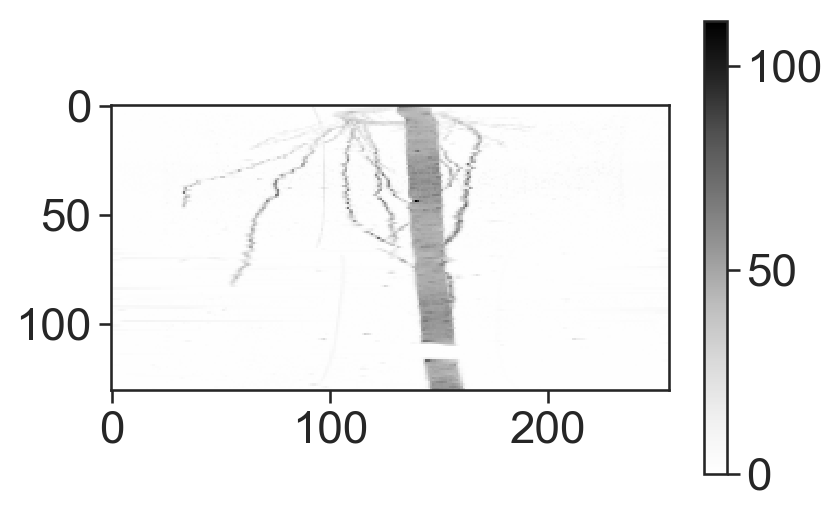

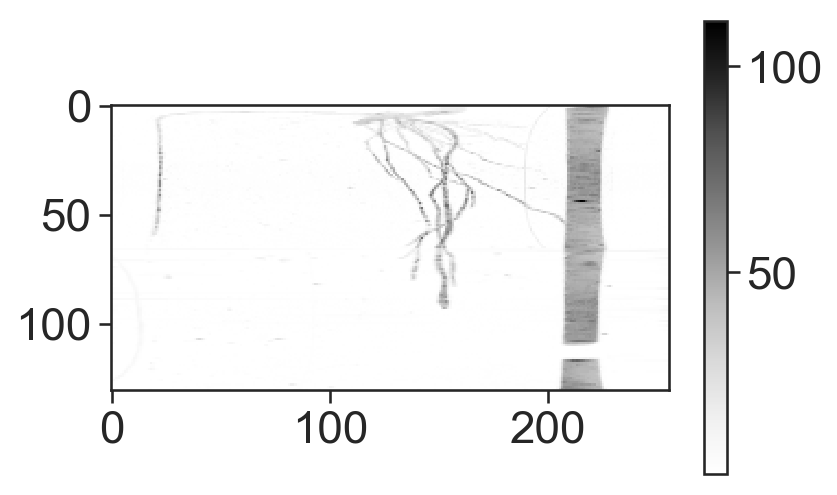

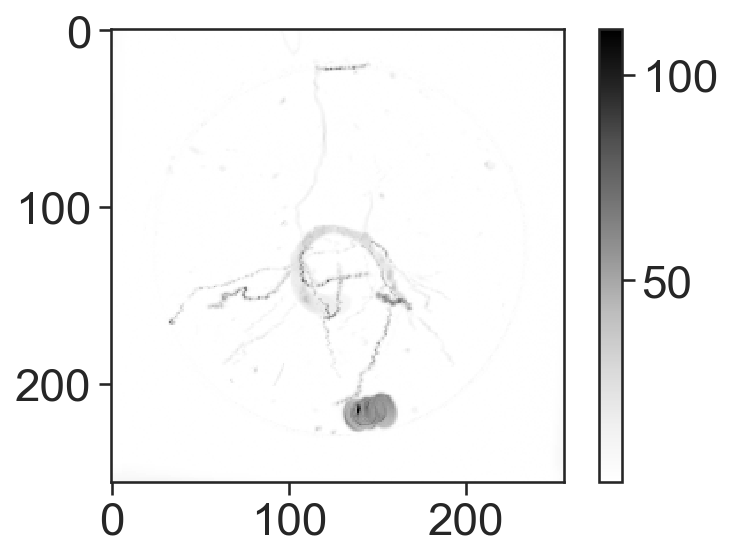

ground truth:


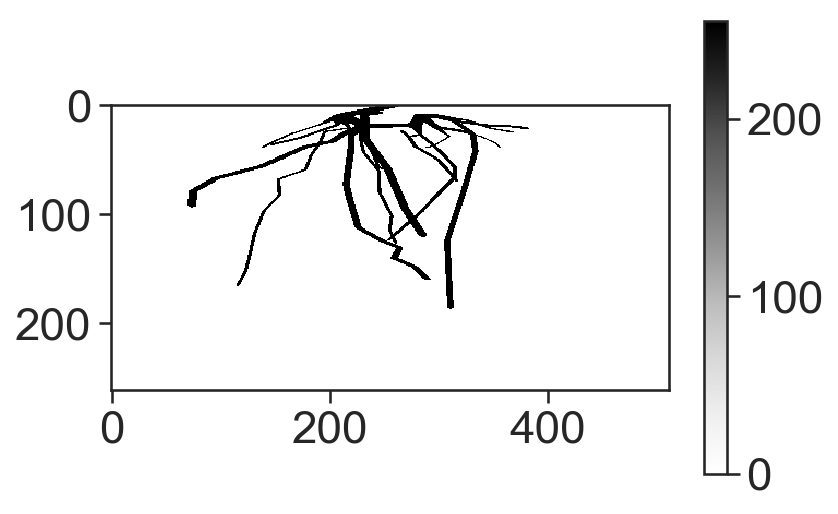

segmentation output:
(262, 512, 512)


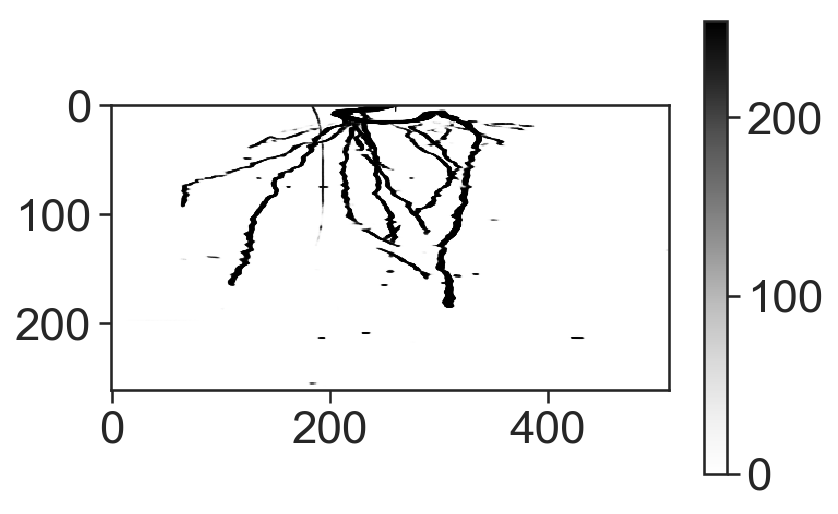

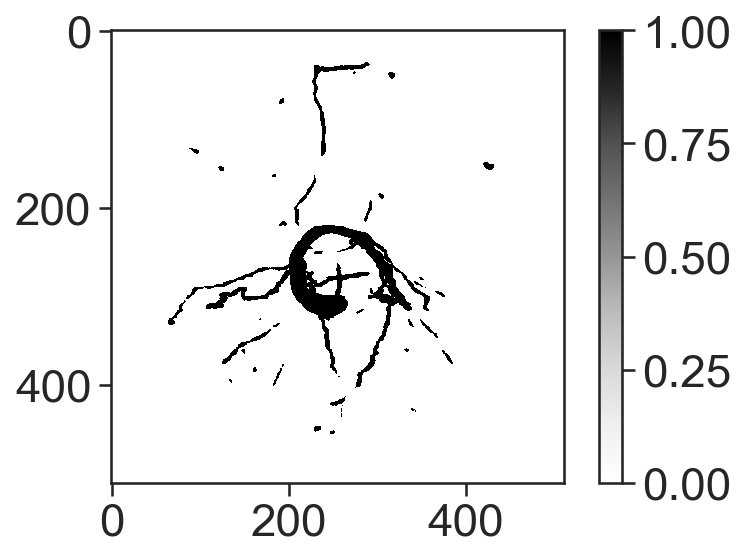

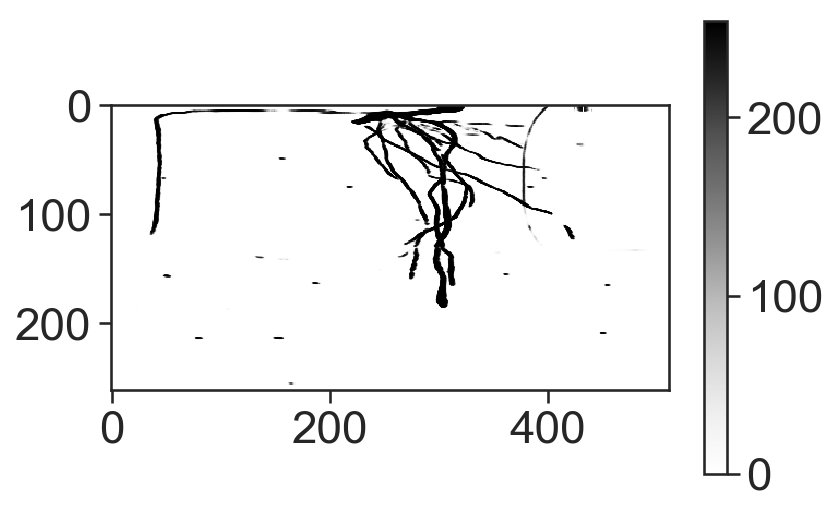

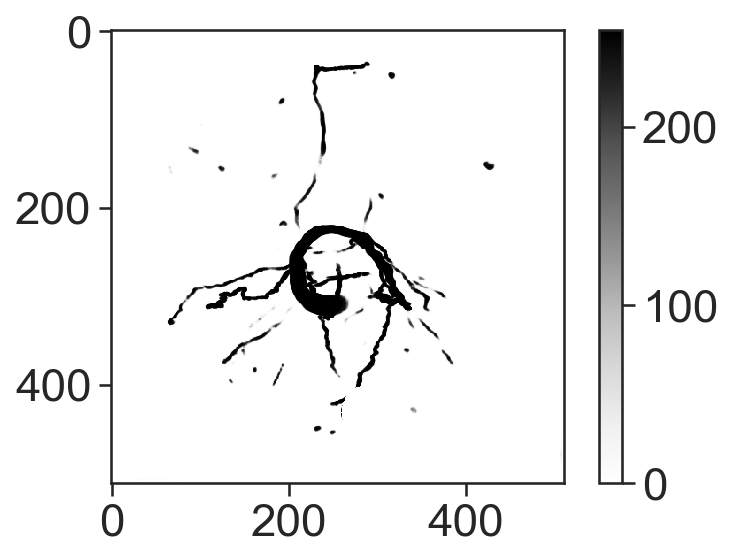

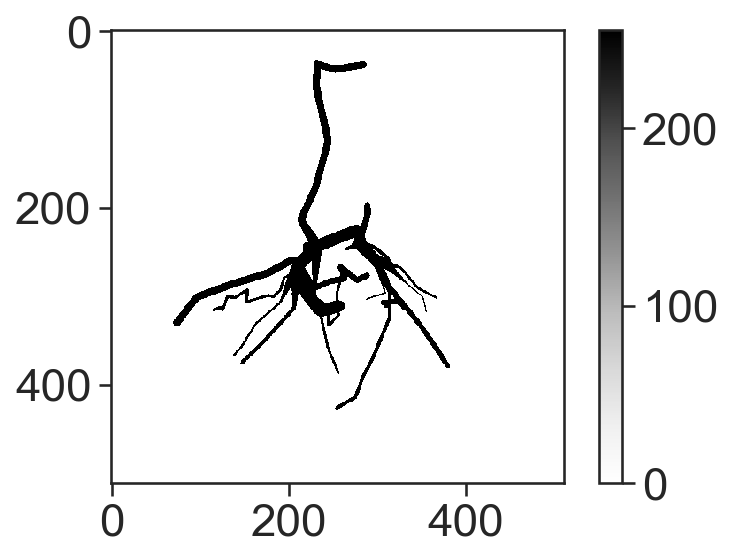


lupine_small_xml_mri.npy
(128, 256, 256)


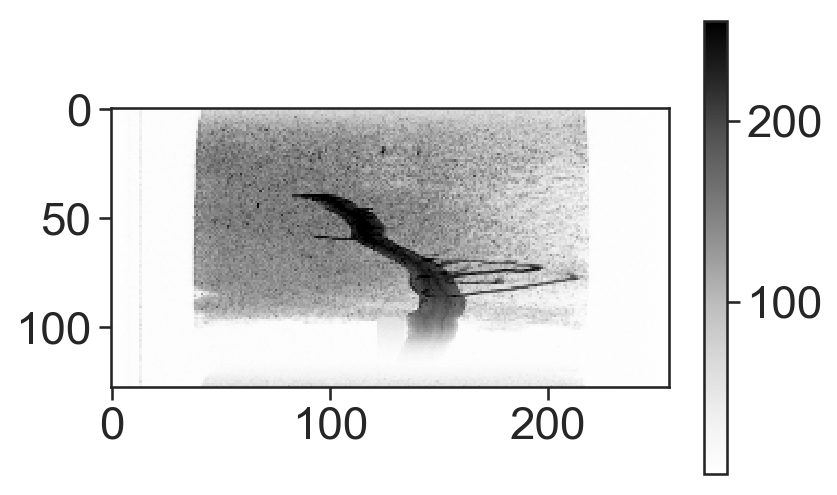

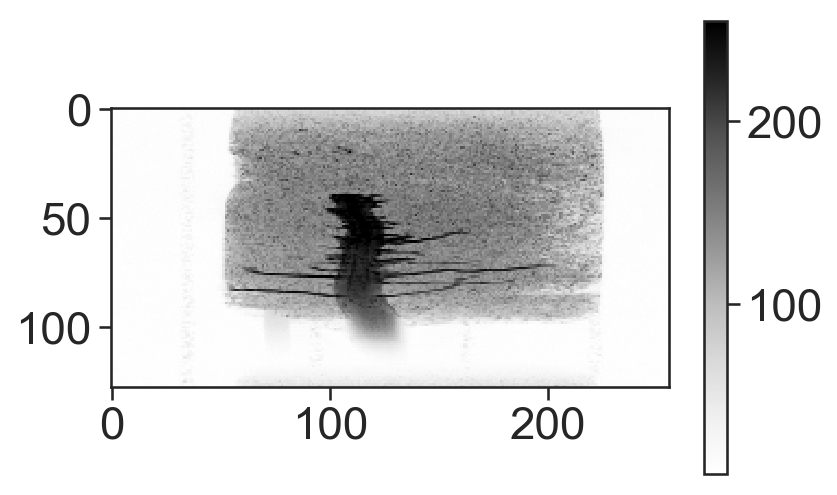

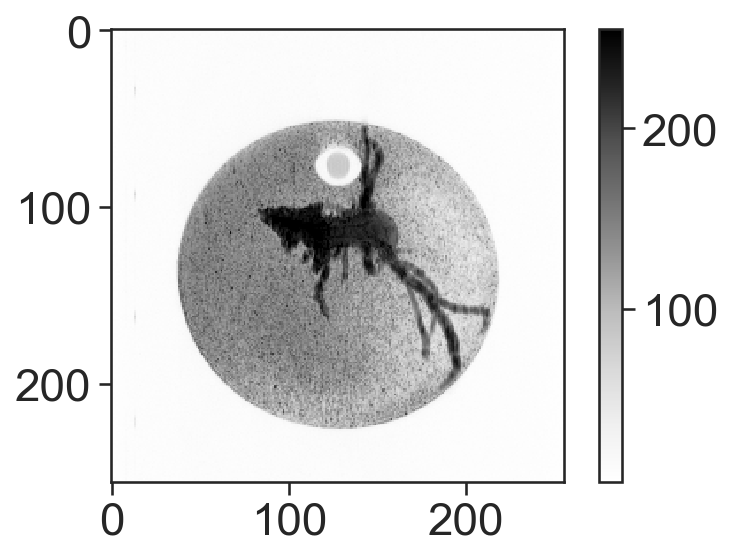

ground truth:


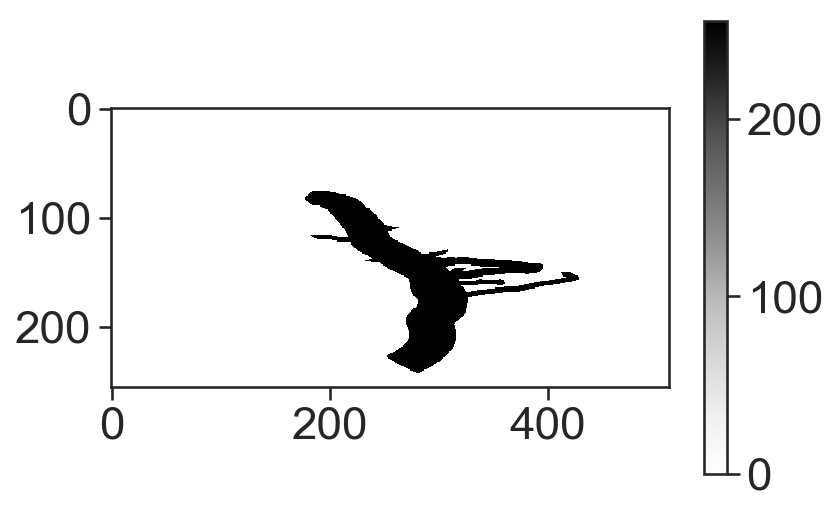

segmentation output:
(256, 512, 512)


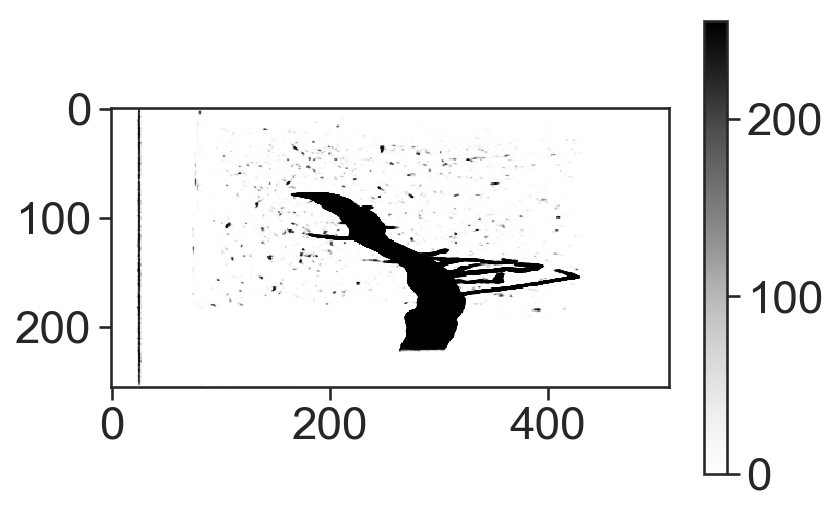

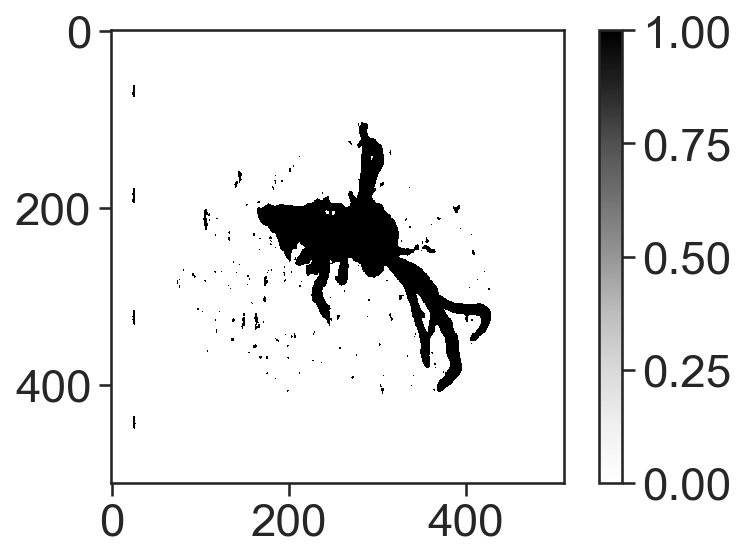

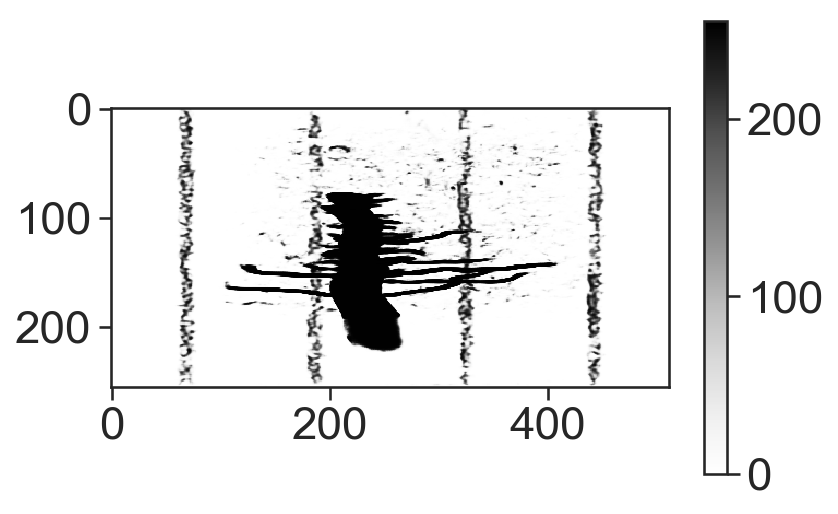

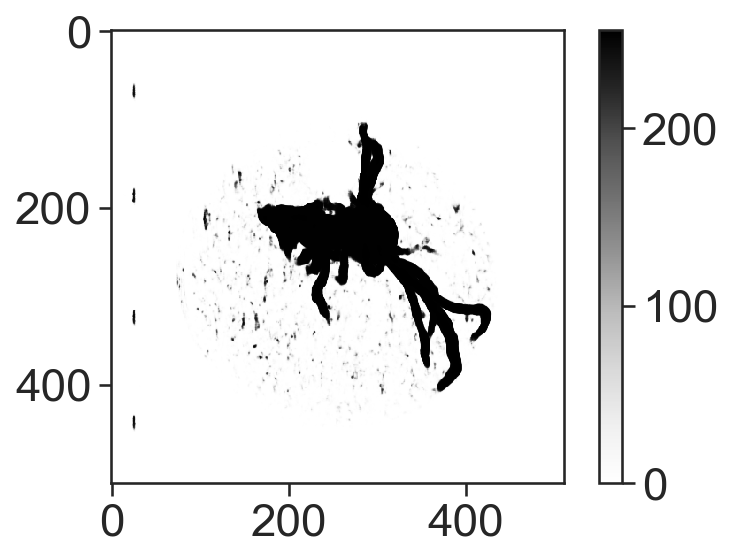

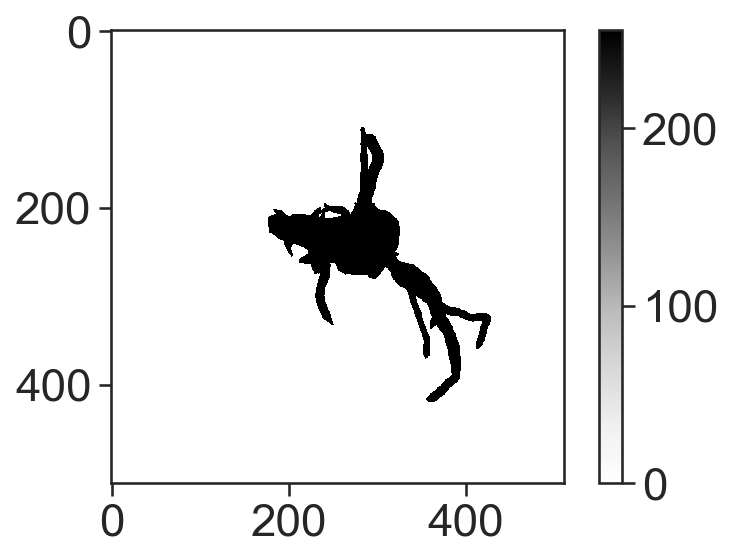


Lupine_22august_mri.npy
(120, 256, 256)


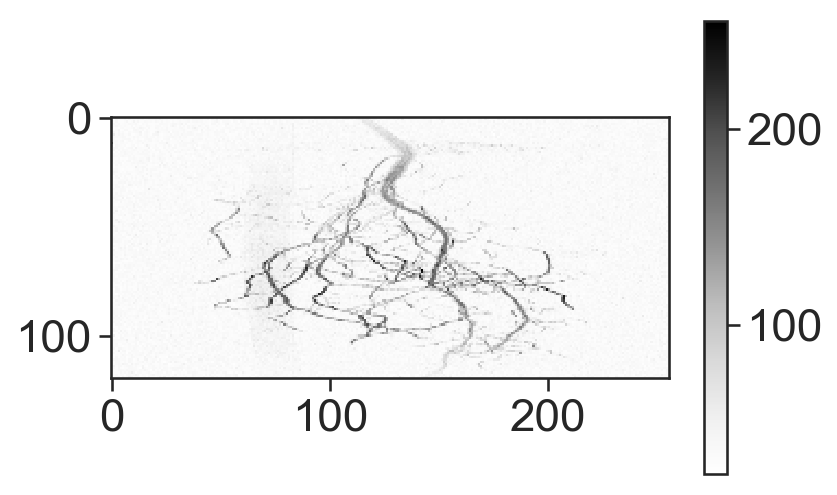

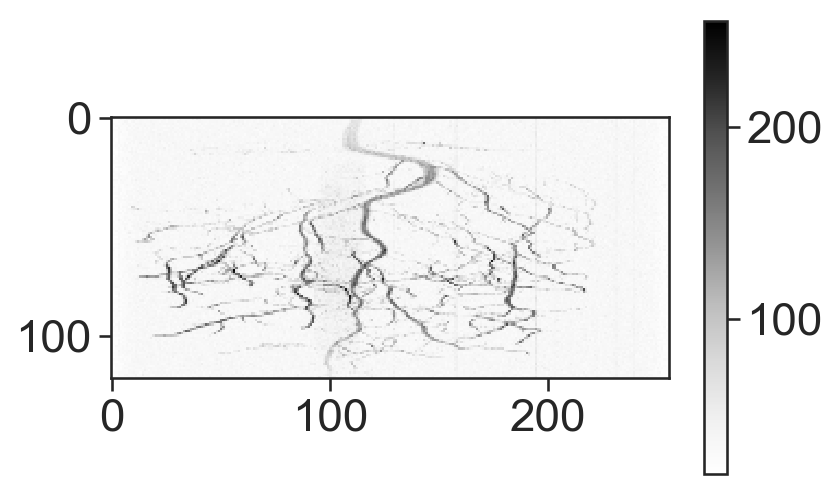

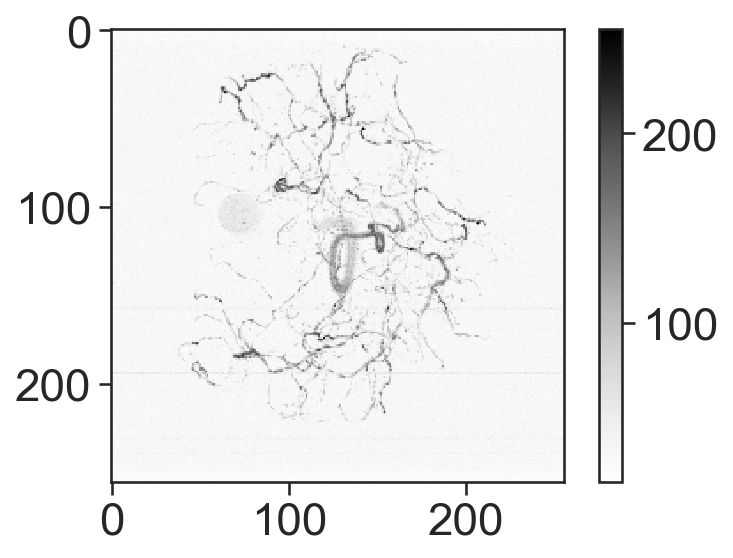

ground truth:


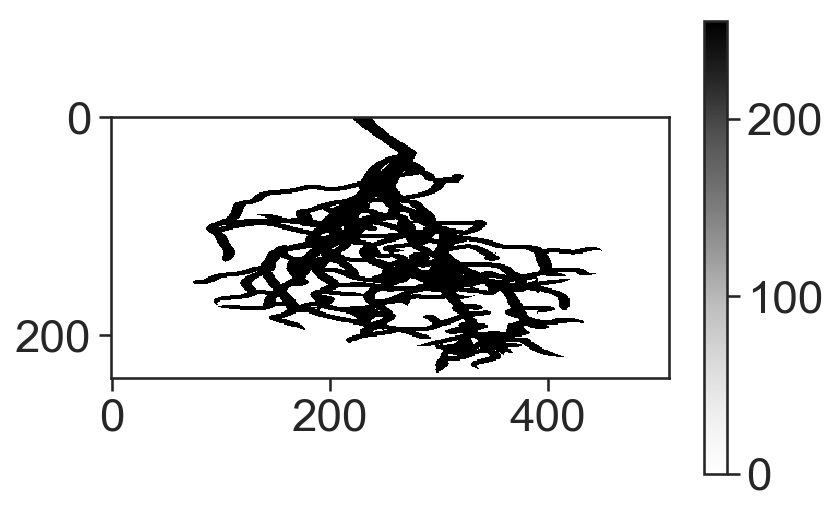

segmentation output:
(240, 512, 512)


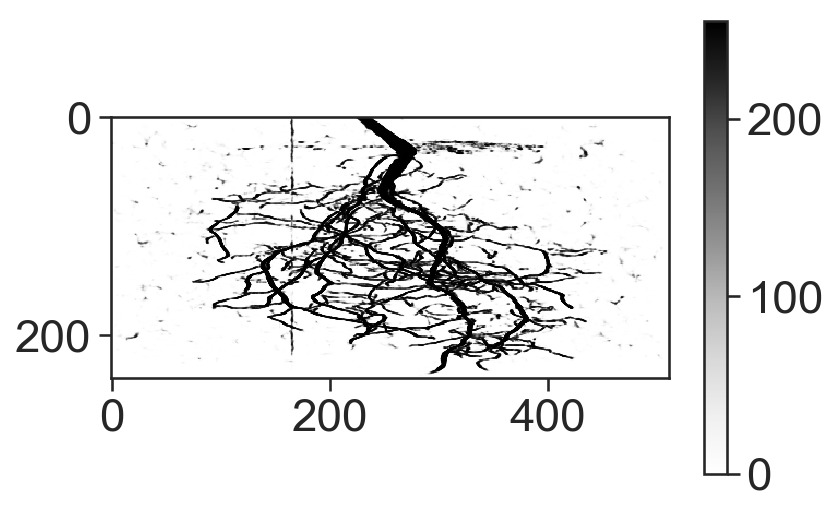

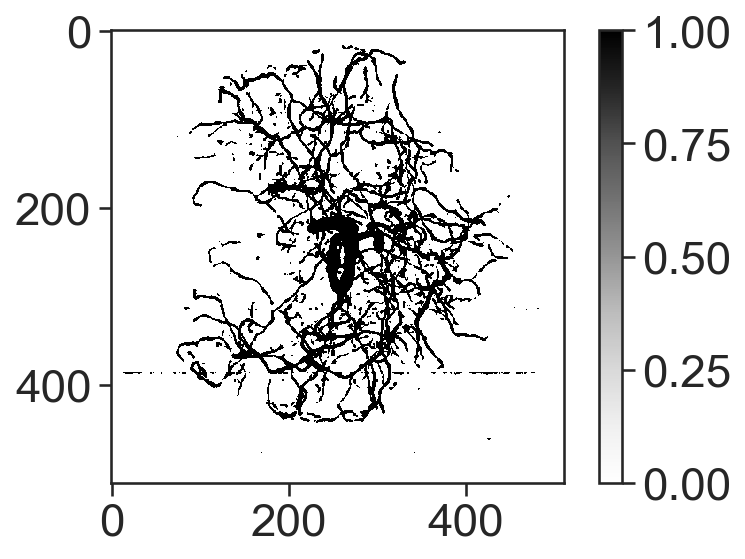

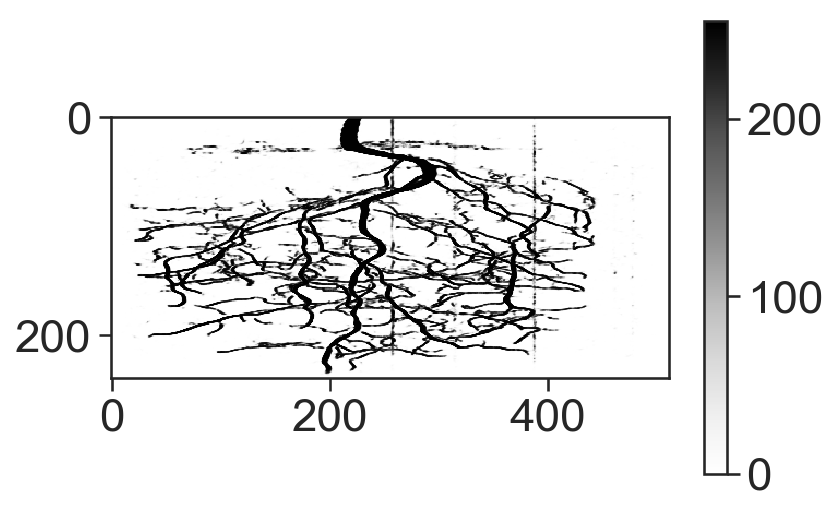

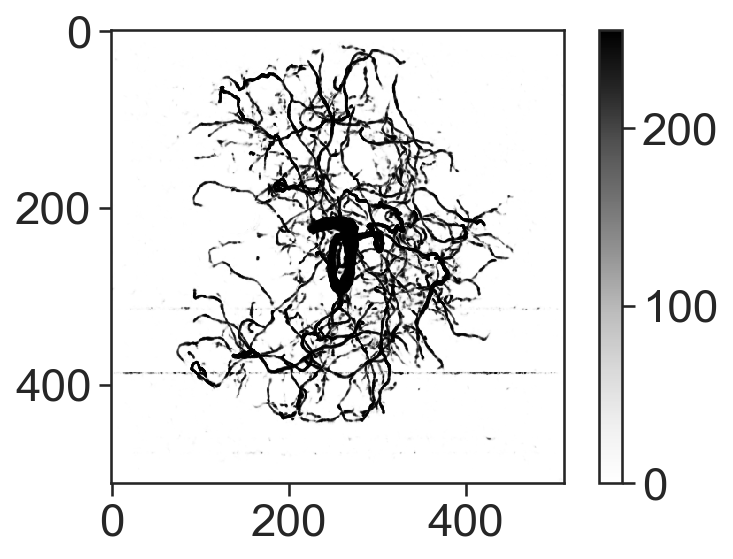

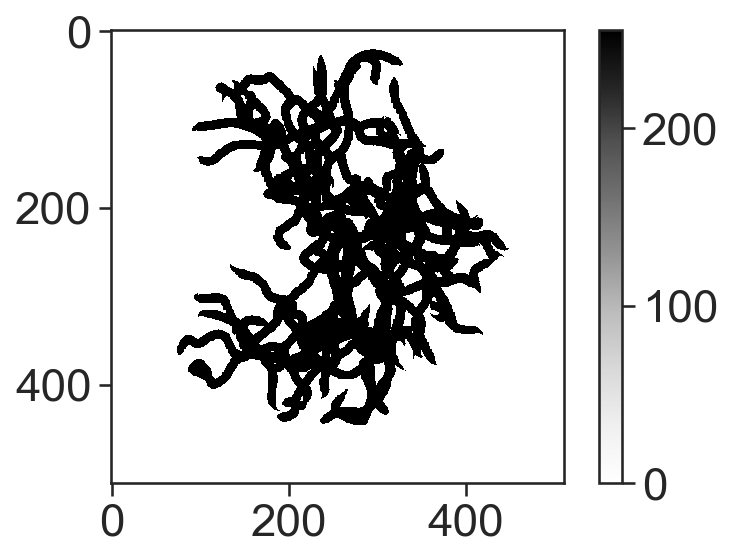


I_Sand_3D_DAP5_mri.npy
(70, 256, 256)


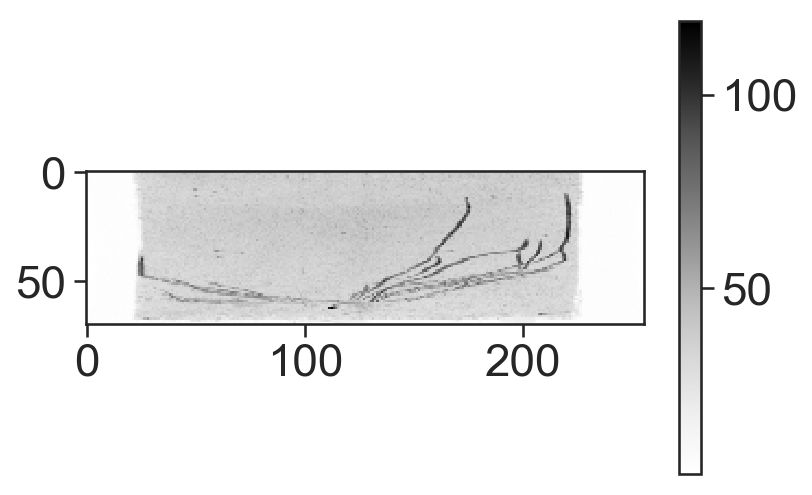

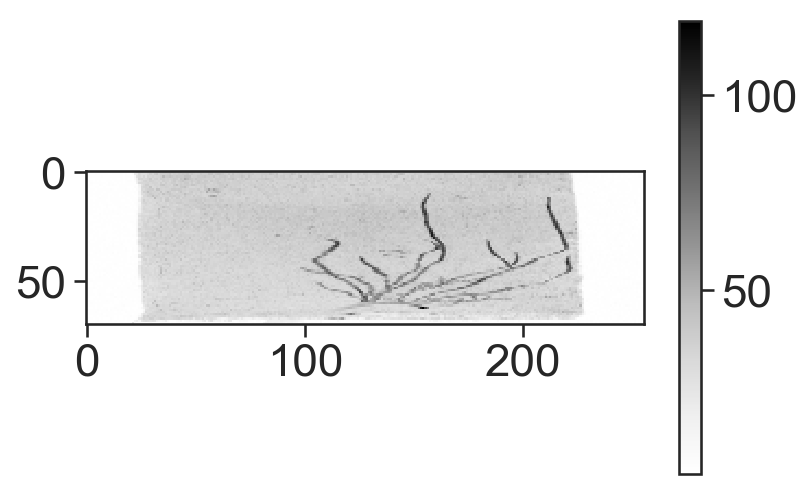

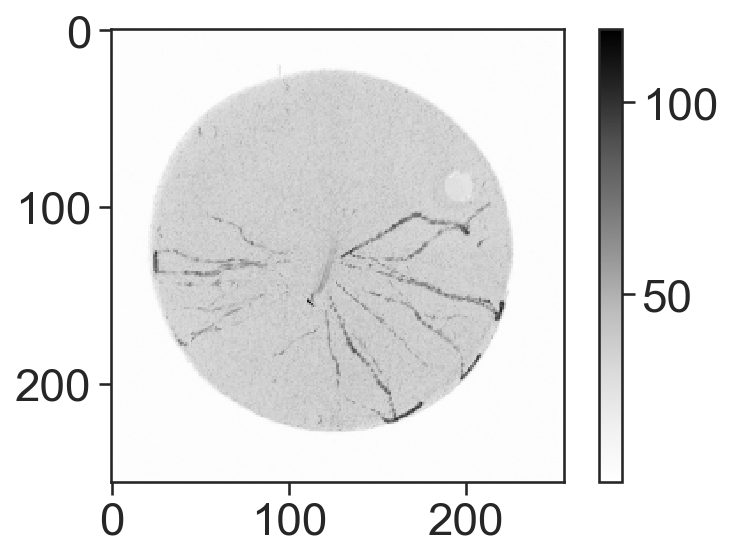

ground truth:


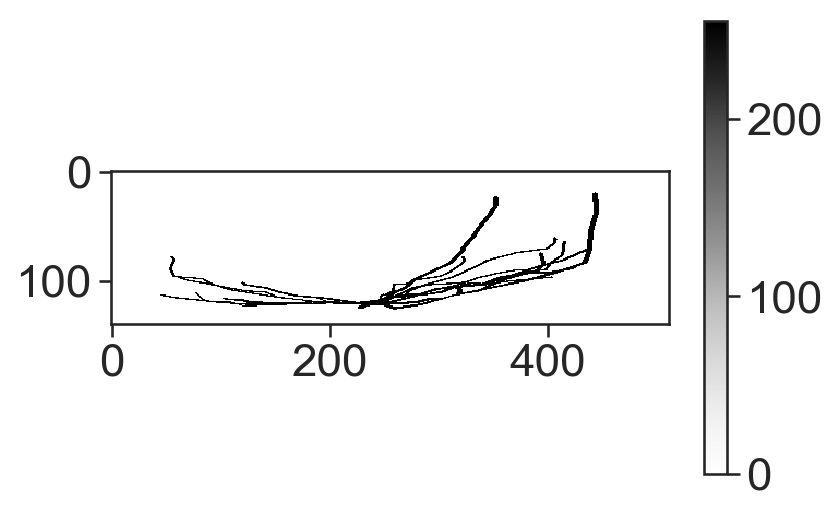

segmentation output:
(140, 512, 512)


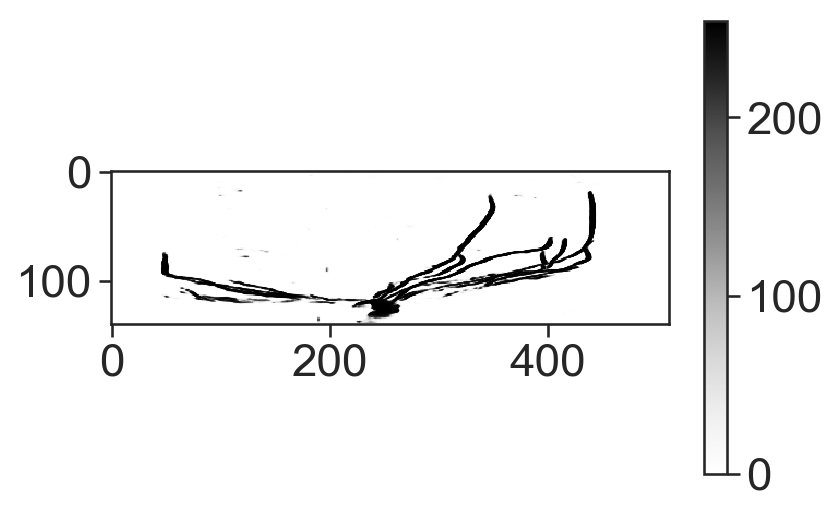

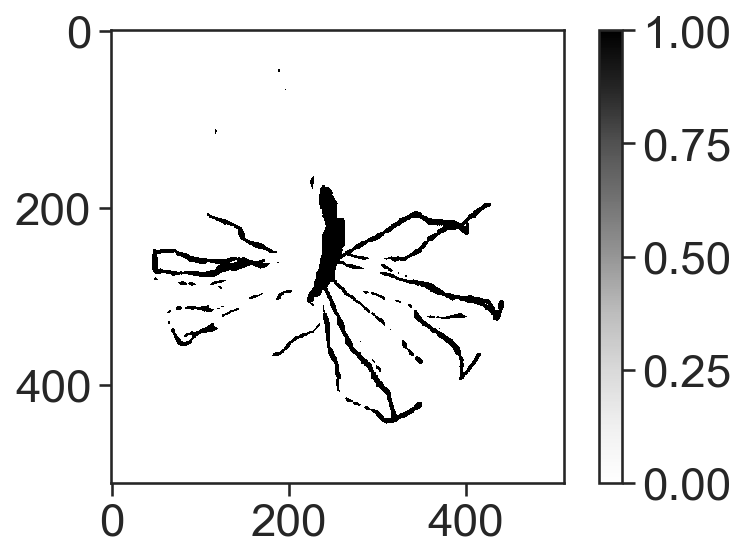

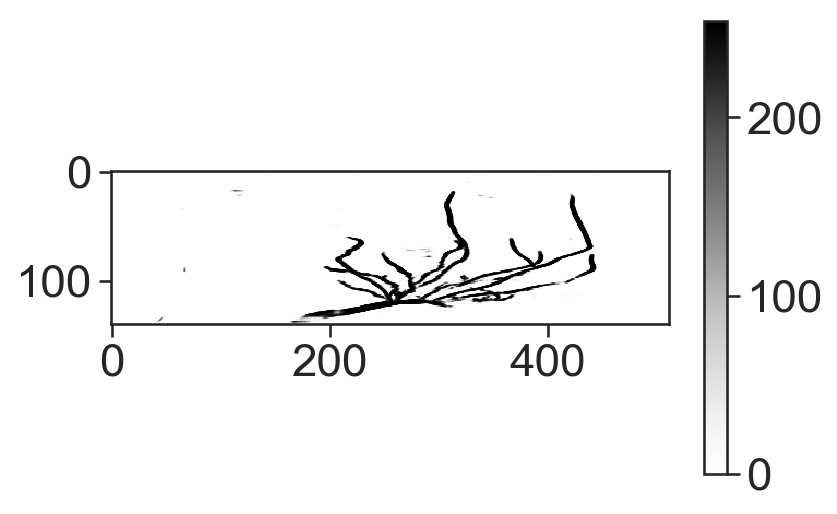

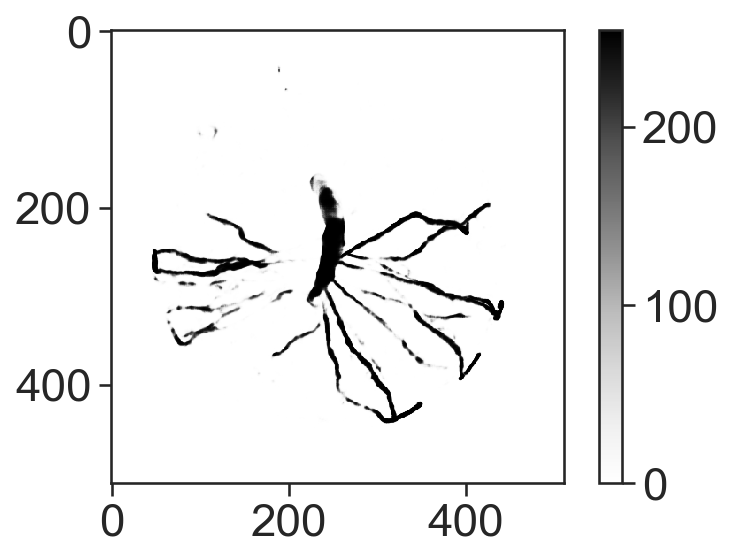

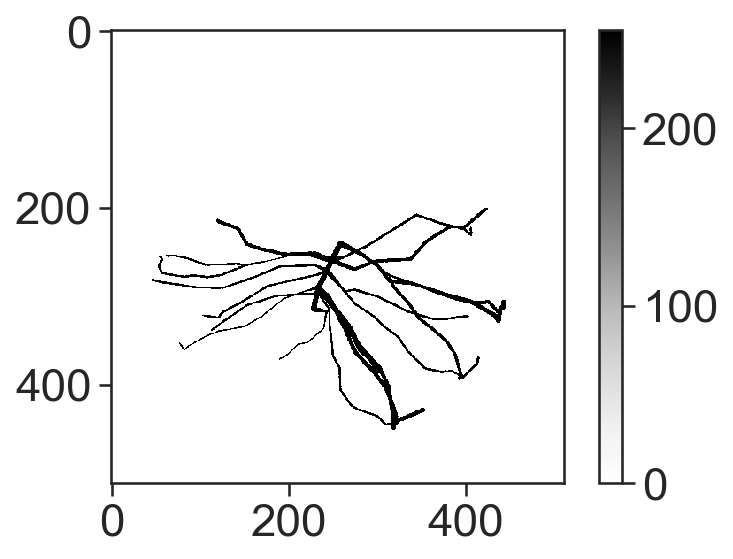


I_Soil_4D_DAP7_mri.npy
(137, 256, 256)


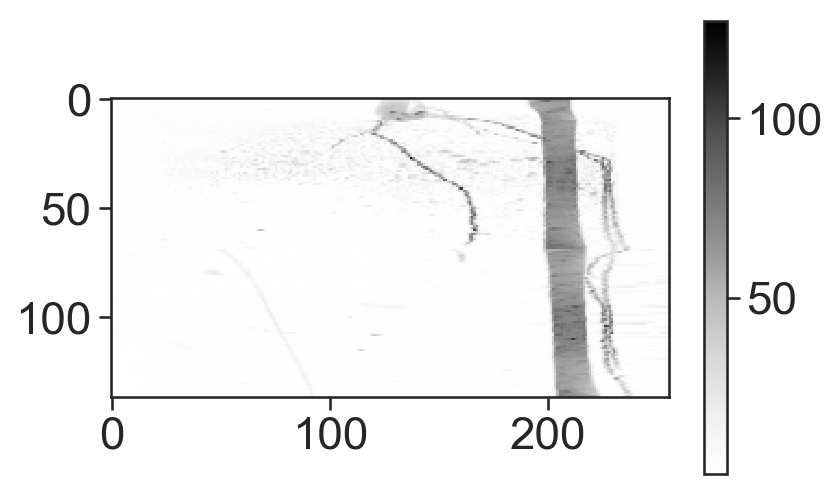

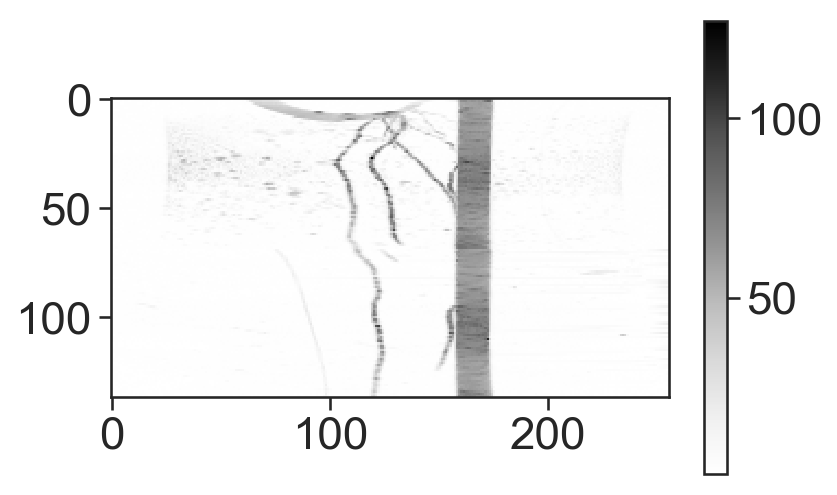

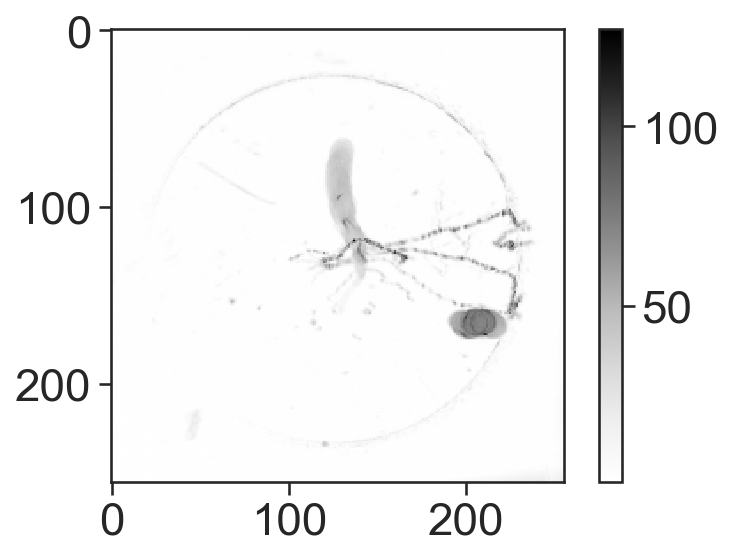

ground truth:


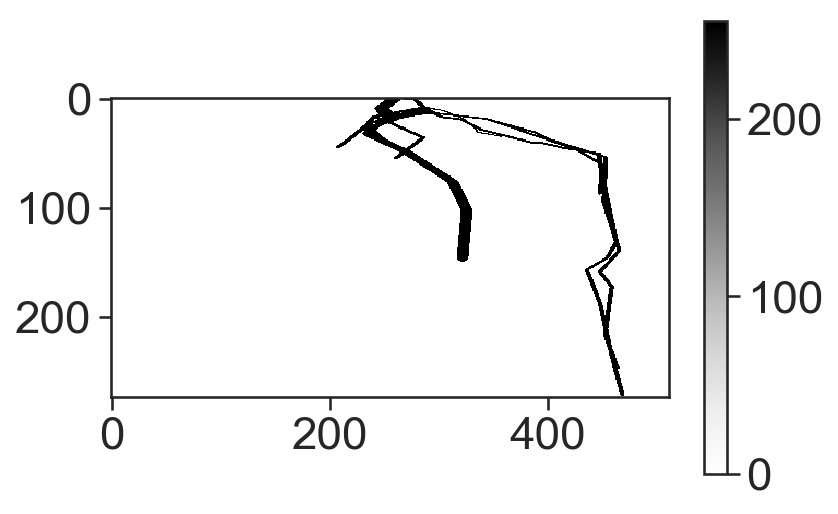

segmentation output:
(274, 512, 512)


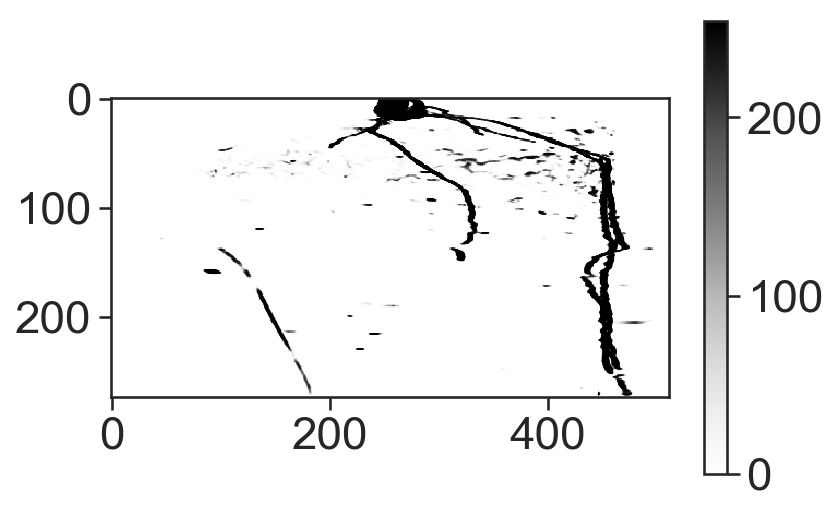

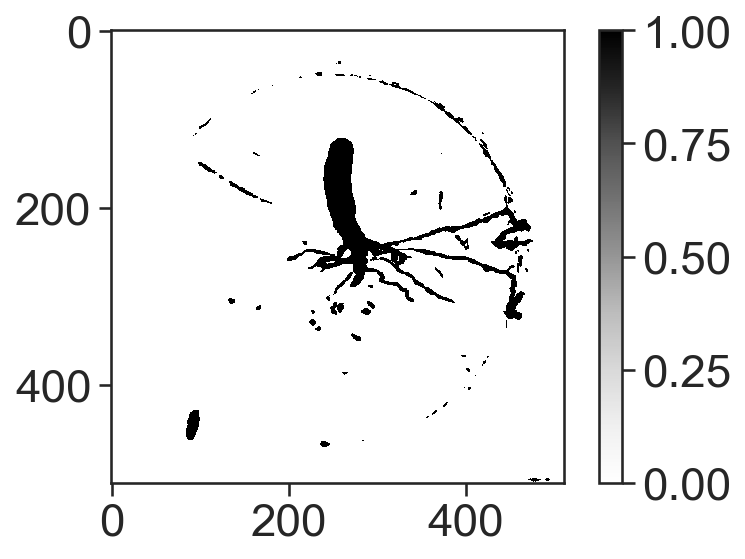

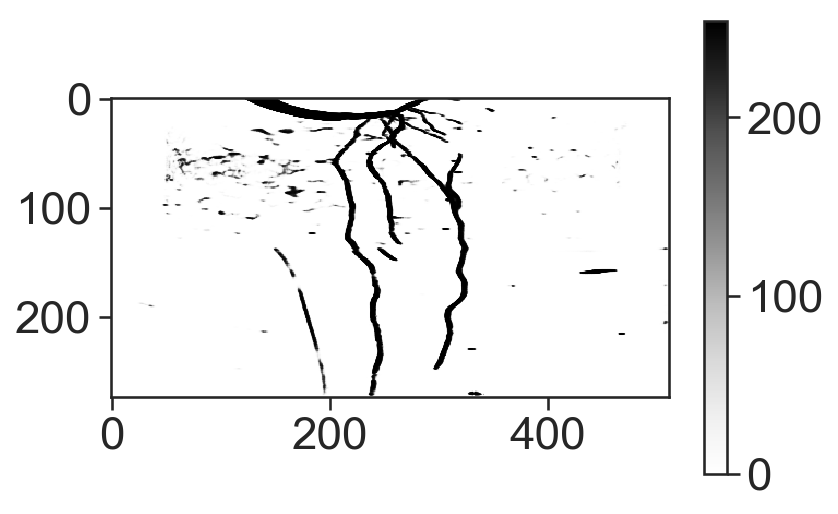

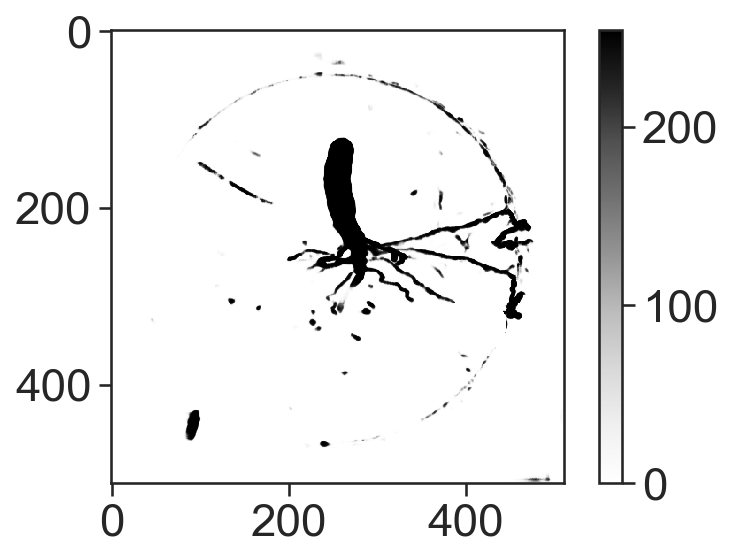

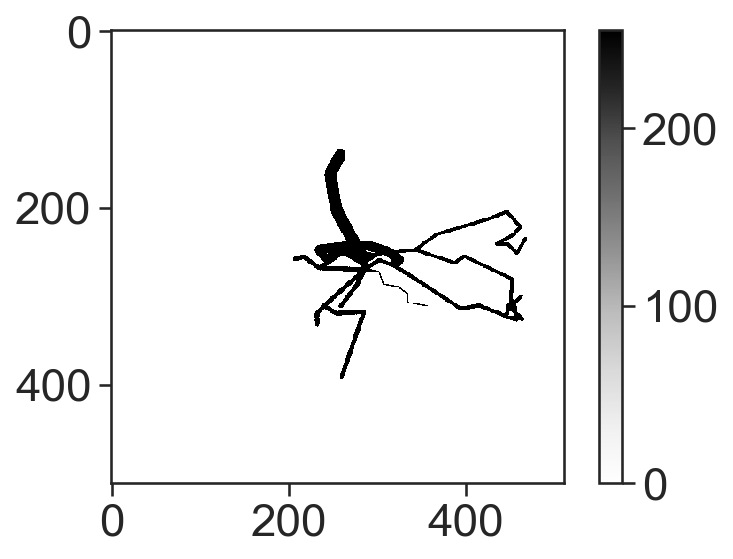

In [166]:
outcrop_overlap = 0
out_dir = join(vis_output_dir, model_name, 'model_{}'.format(training_step), 'outcrop_overlap{}'.format(outcrop_overlap))
gt_dir = join(test_data_dir, 'ground_truth')
probability_threshold = 0.5
sns.set_style('ticks')


for fn in os.listdir(test_data_dir):
    if fn.endswith('.npy'):
        print(fn)
        img = np.load(join(test_data_dir, fn))
        img = np.squeeze(img)
        print(img.shape)
#         plot_one_slice(img, 'x', img.shape[1]//2)
        plot_merged_slices(img, 'x', 0, img.shape[1])
        plot_merged_slices(img, 'y', 0, img.shape[2])
        plot_merged_slices(img, 'z', 0, img.shape[0])
        
        gt = np.load(join(gt_dir, 'gt_{}x_{}'.format(super_res, fn)))
        gt = np.squeeze(gt)
        print('ground truth:')
        plot_merged_slices(gt, 'x', 0, gt.shape[1])
        
        if fn in tube_mask_info:
            # generate the test tube mask for this data
            center_x = tube_mask_info[fn]['center_x'] * super_res
            center_y = tube_mask_info[fn]['center_y'] * super_res
            rad = tube_mask_info[fn]['radius'] * super_res
            tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)
        
        out = np.load(join(out_dir, 'visualized_out_'+fn.strip('.npy')+'.npz'))['arr_0']
        print('segmentation output:')
        print(out.shape)
        # plot_one_slice(out, 'x', out.shape[1]//2)
        if fn in tube_mask_info:
            out[tube_mask] = 0
        plot_merged_slices(out, 'x', 0, out.shape[1])
        plot_merged_slices((out>255*probability_threshold).astype(int), 'z', 0, out.shape[0])
        plot_merged_slices(out, 'y', 0, out.shape[2])
        plot_merged_slices(out, 'z', 0, out.shape[0])
        plot_merged_slices(gt, 'z', 0, gt.shape[0])
        
        print()

I_Soil_1W_DAP7_mri.npy
(131, 256, 256)


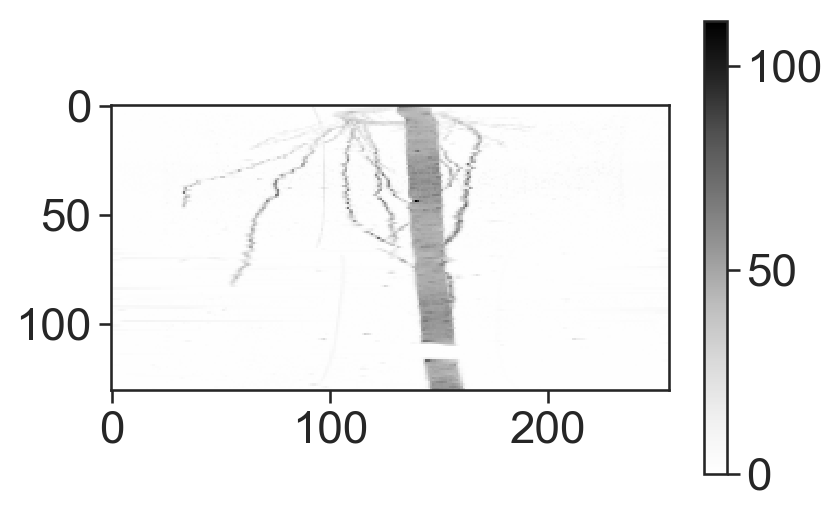

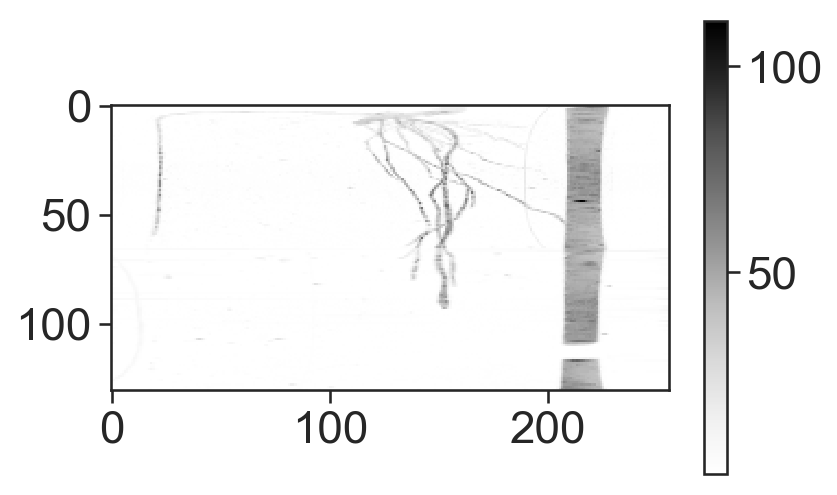

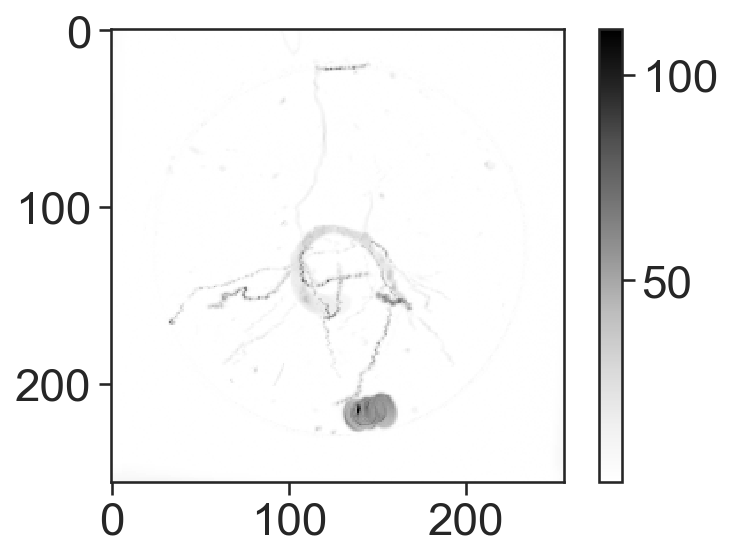

ground truth:


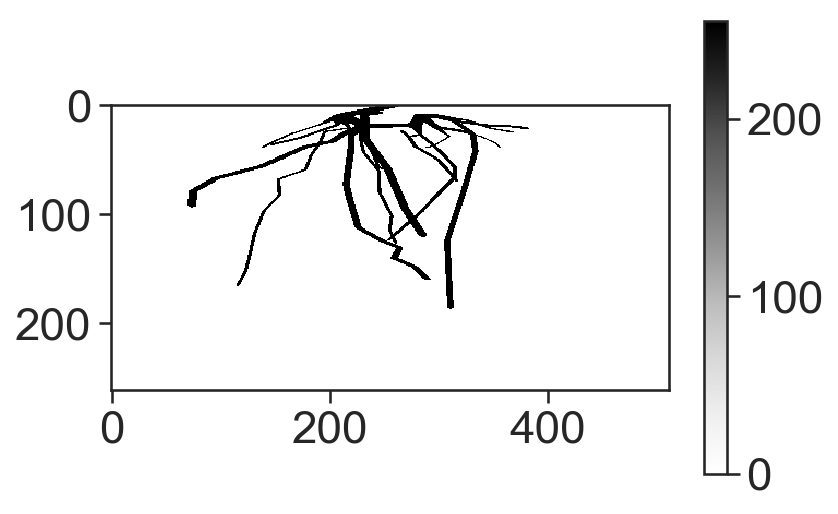

segmentation output:
(262, 512, 512)


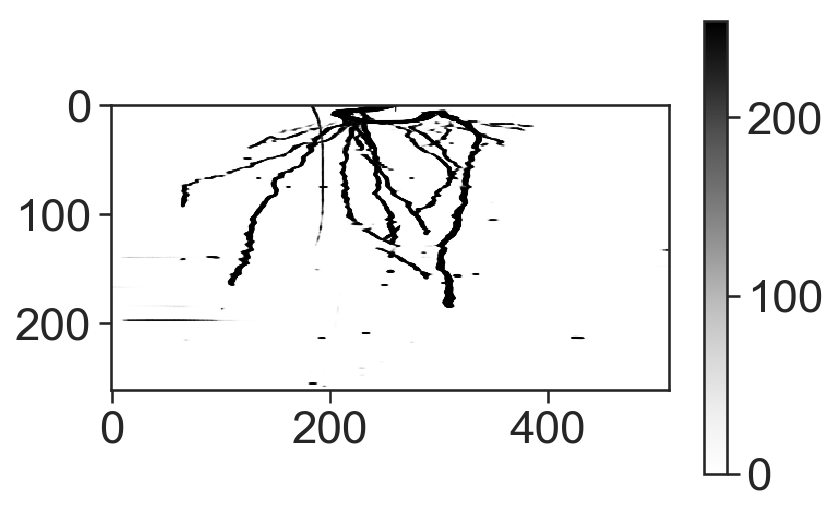

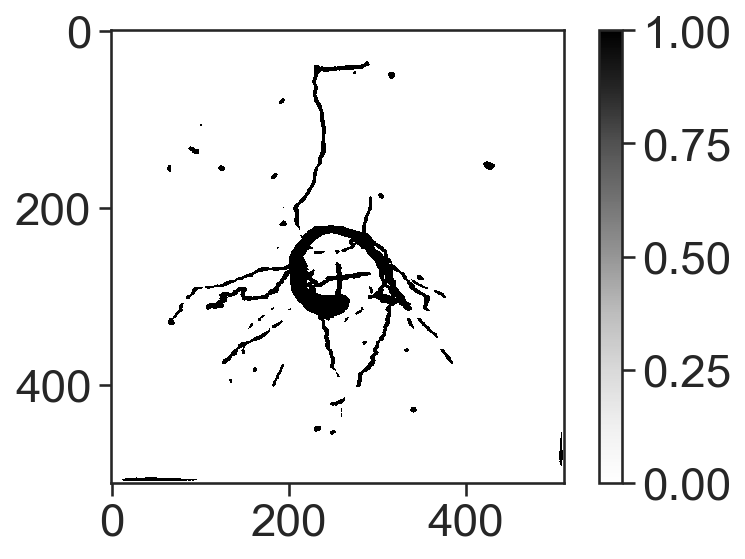

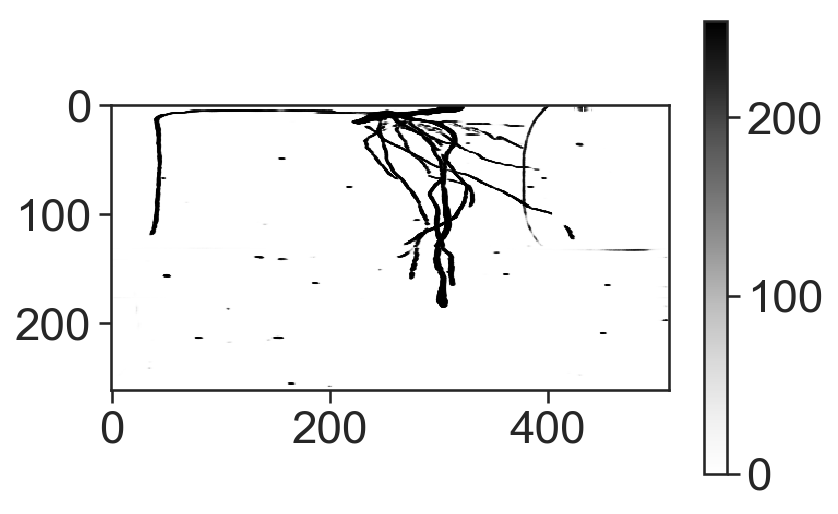

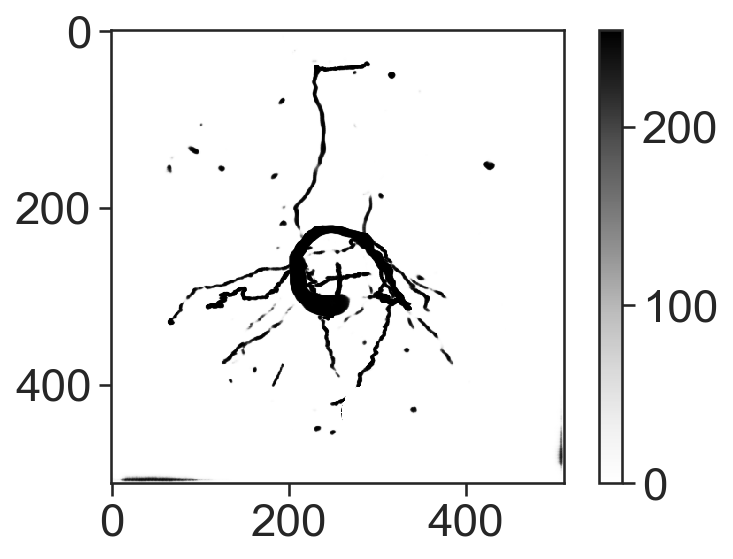

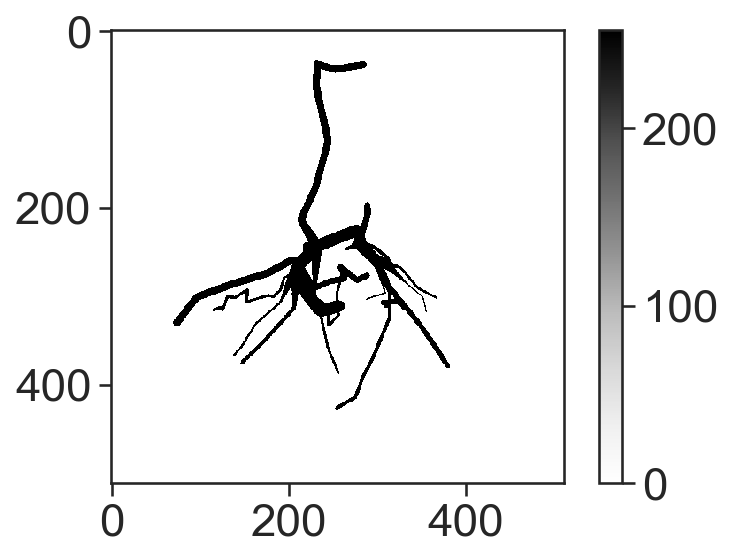


lupine_small_xml_mri.npy
(128, 256, 256)


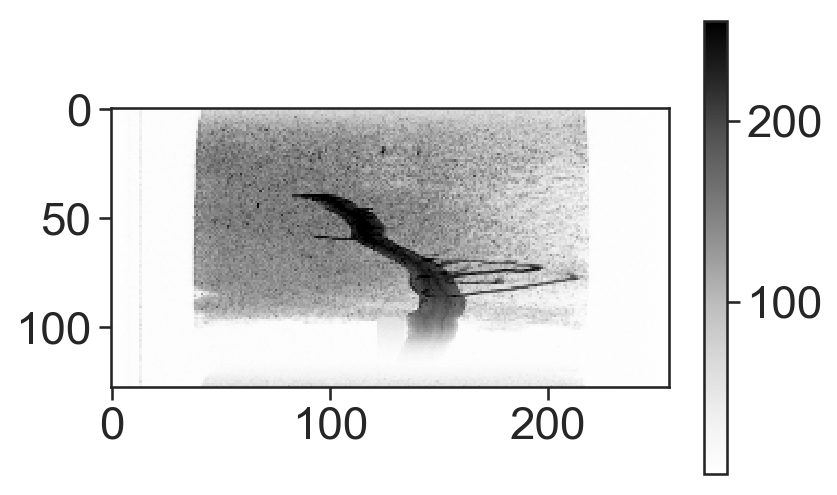

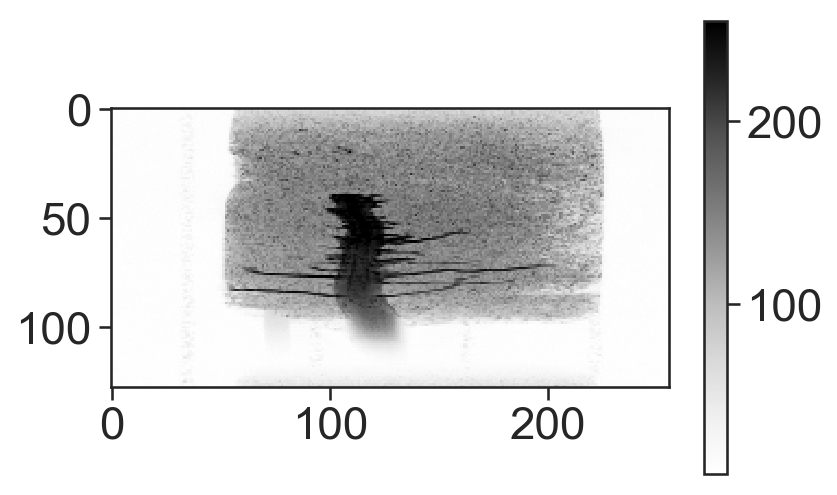

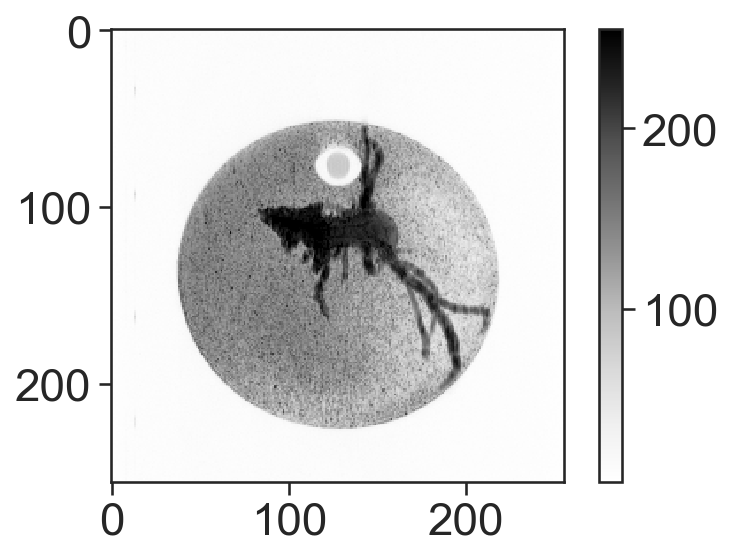

ground truth:


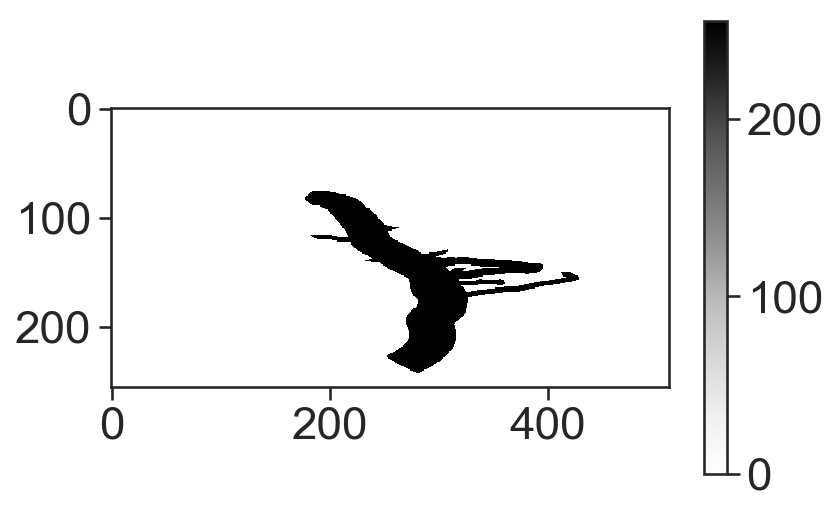

segmentation output:
(256, 512, 512)


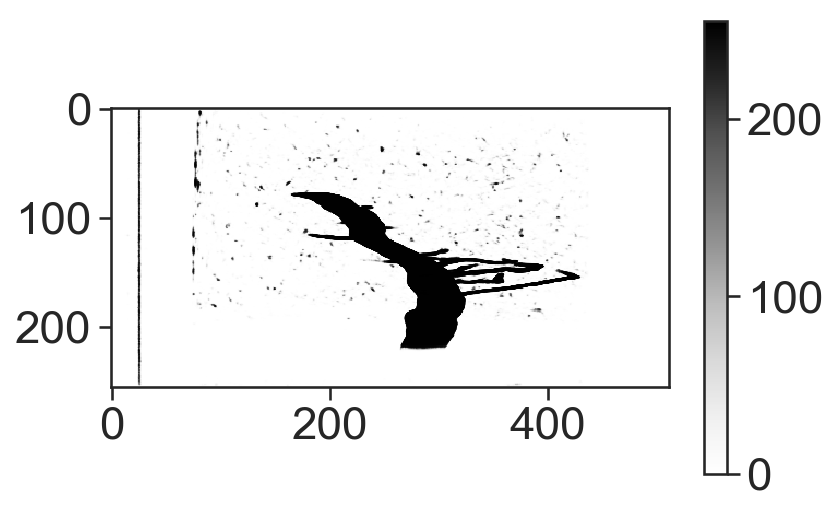

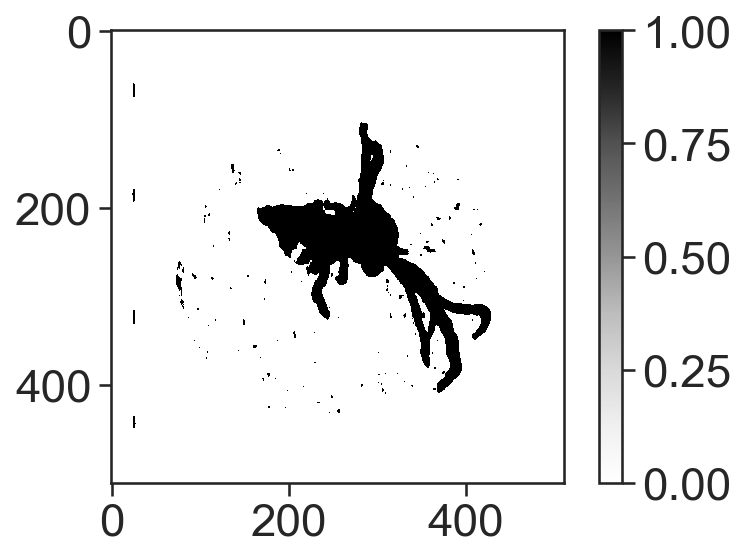

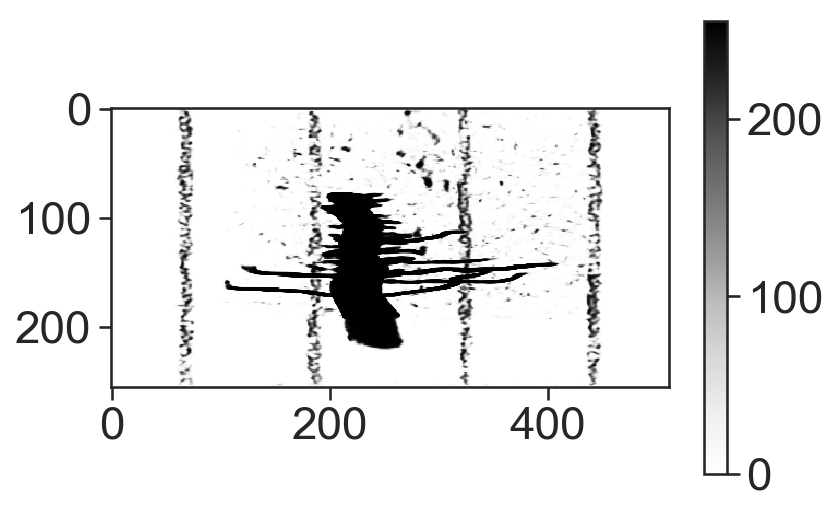

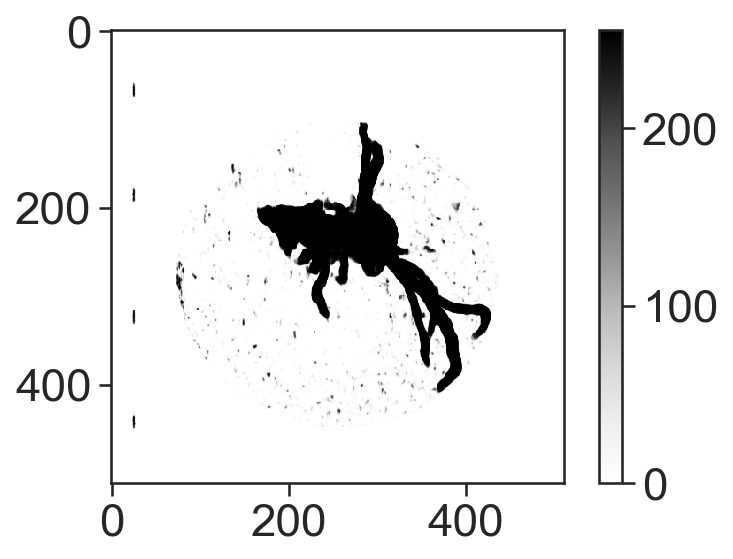

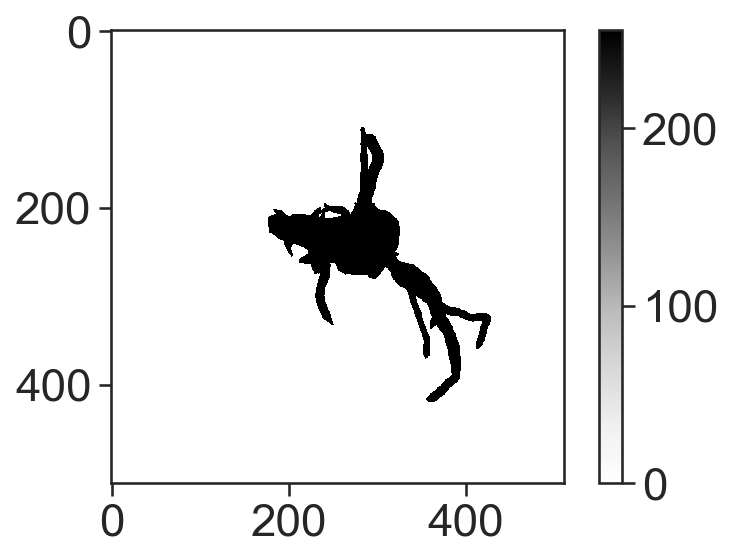


Lupine_22august_mri.npy
(120, 256, 256)


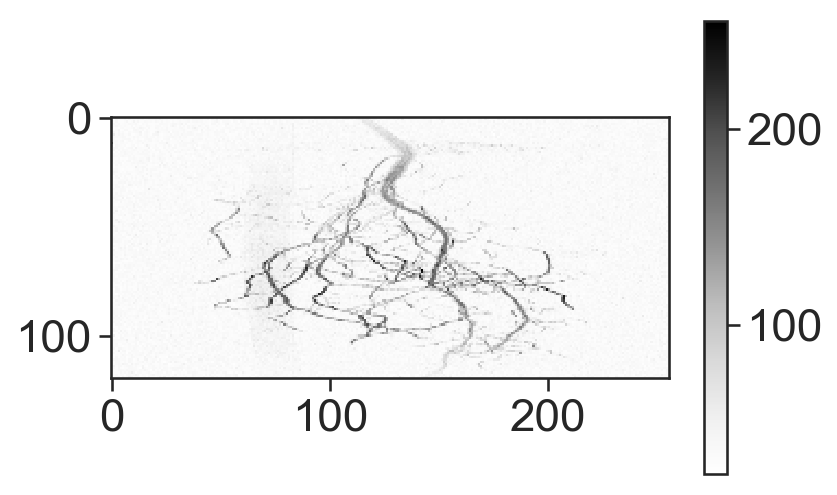

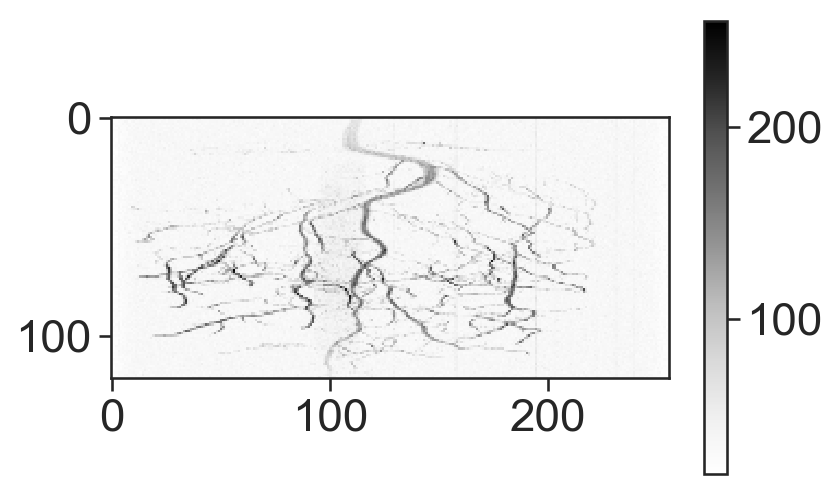

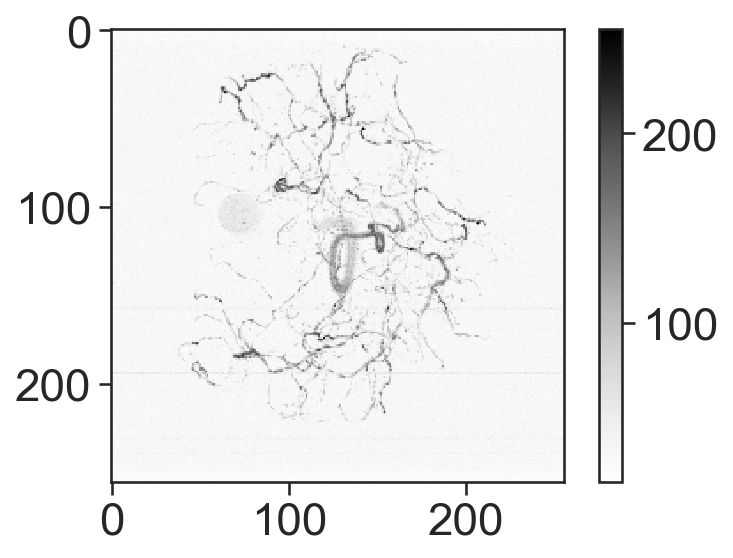

ground truth:


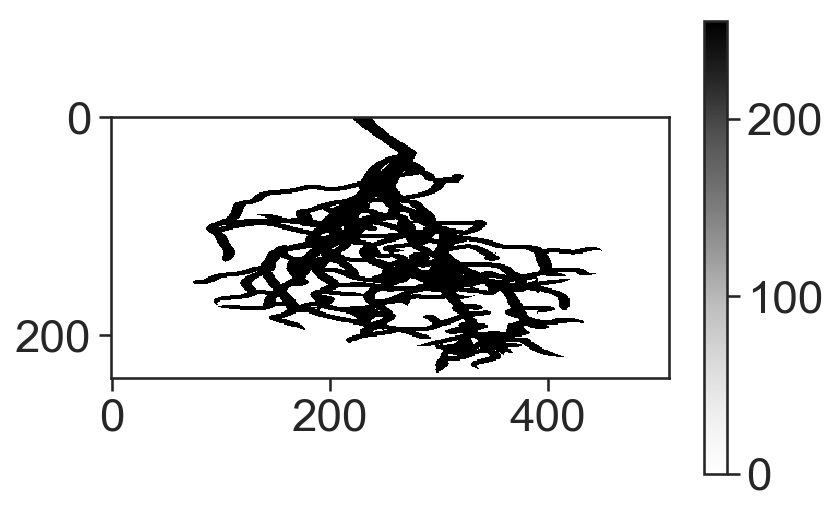

segmentation output:
(240, 512, 512)


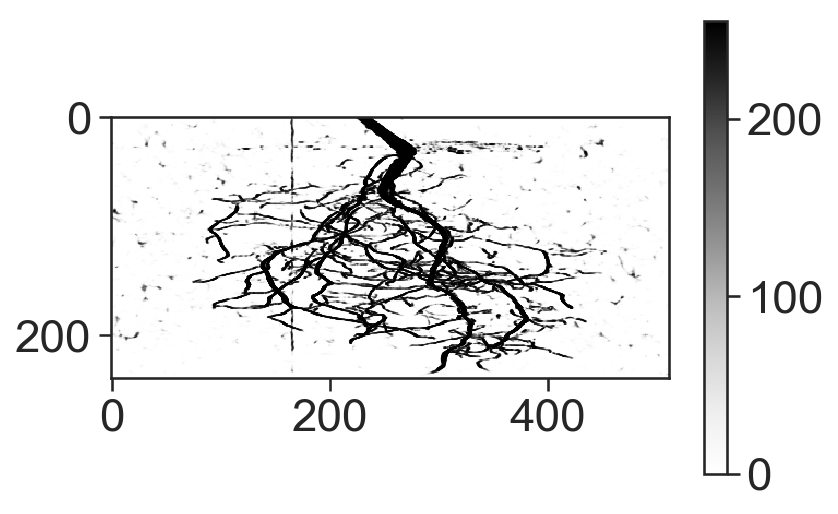

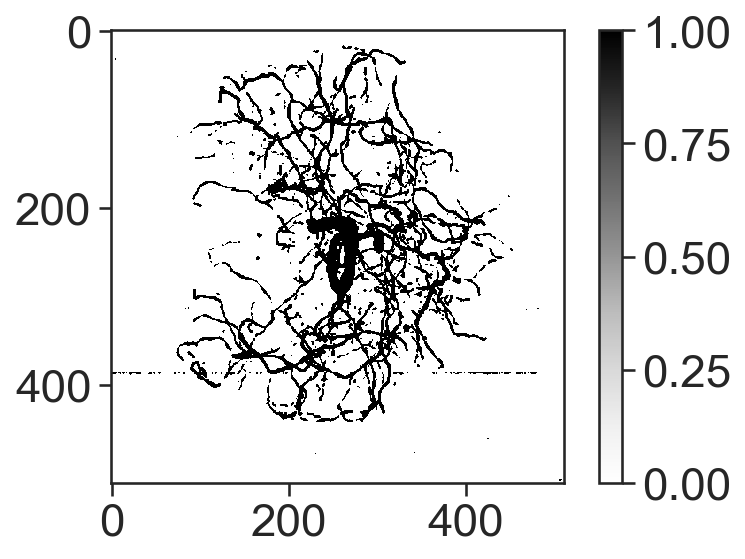

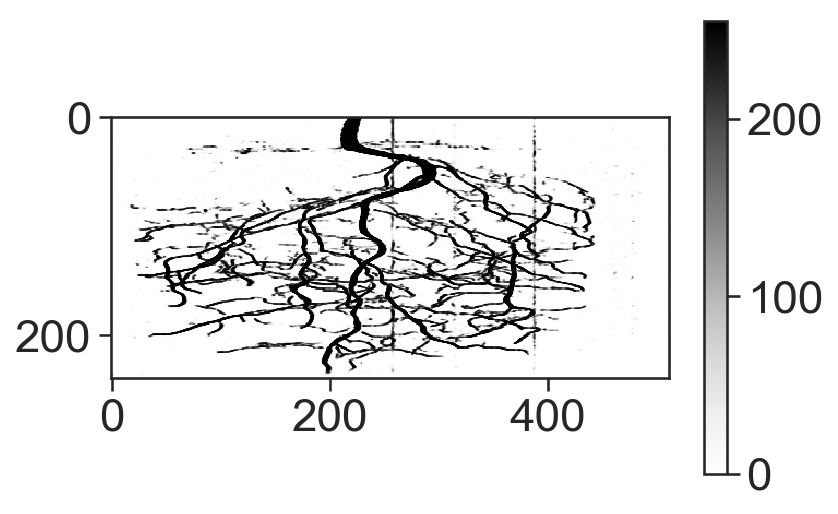

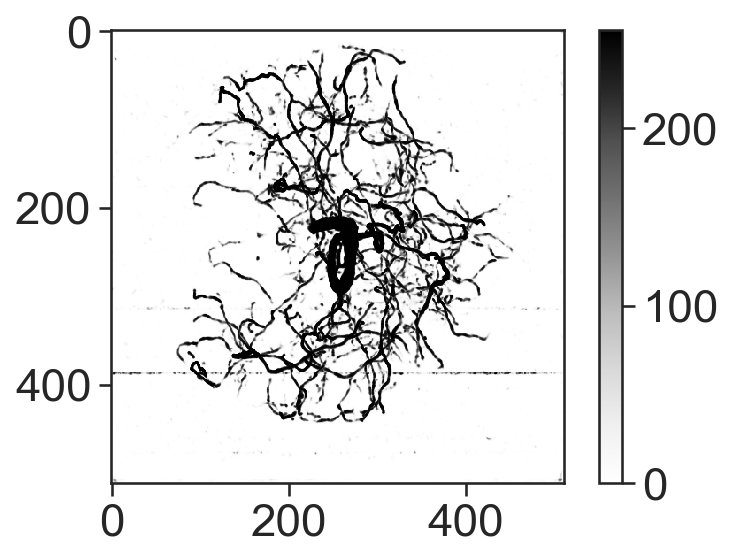

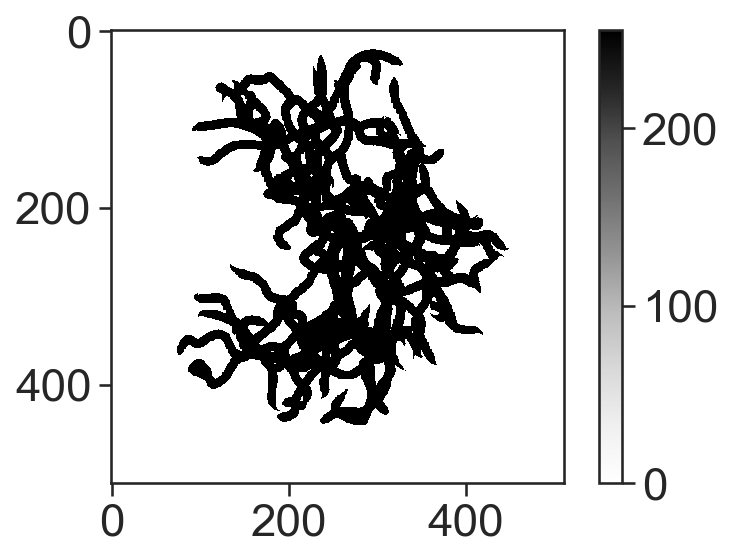


I_Sand_3D_DAP5_mri.npy
(70, 256, 256)


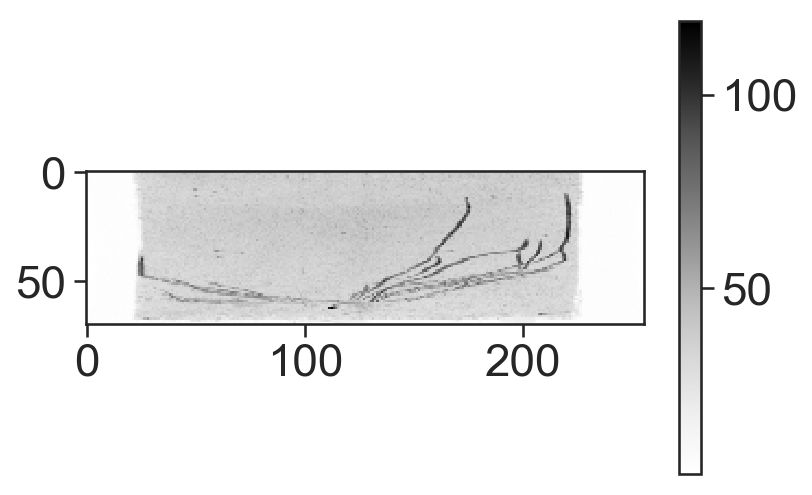

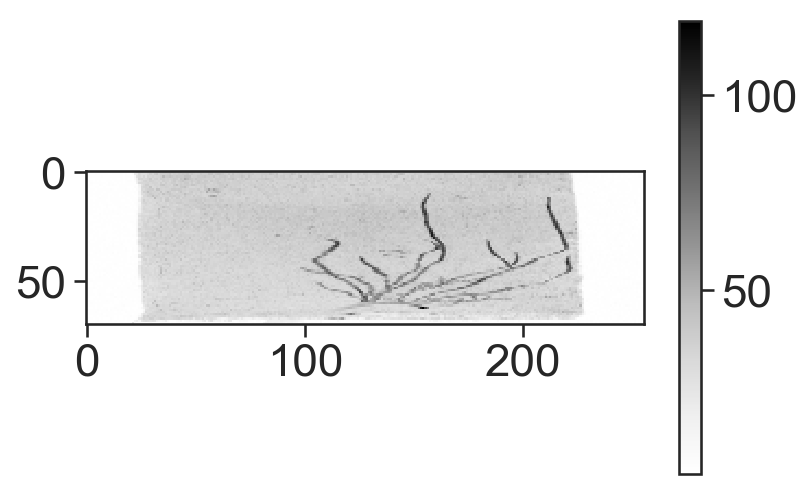

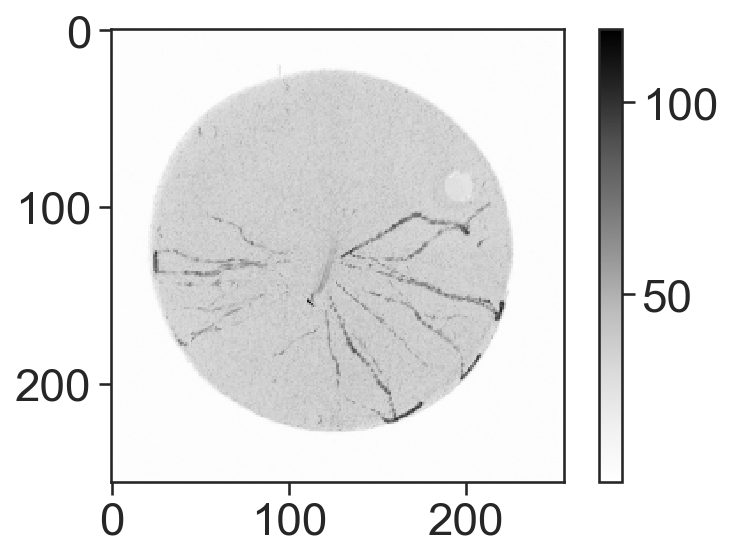

ground truth:


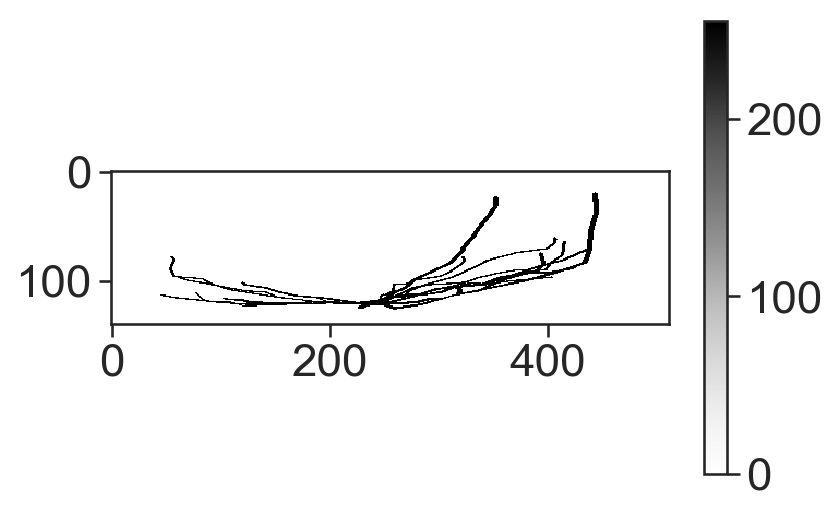

segmentation output:
(140, 512, 512)


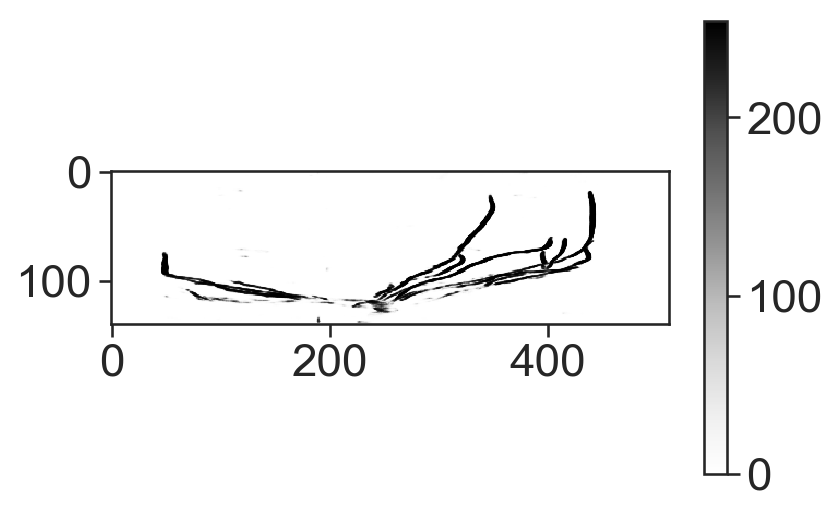

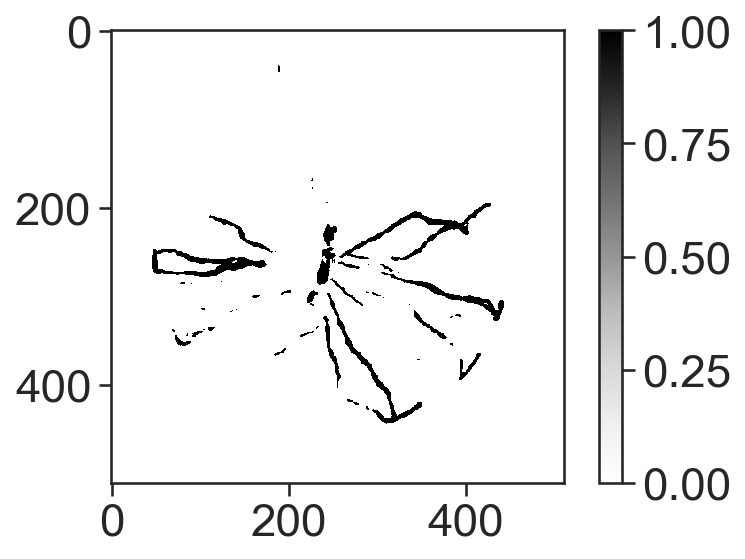

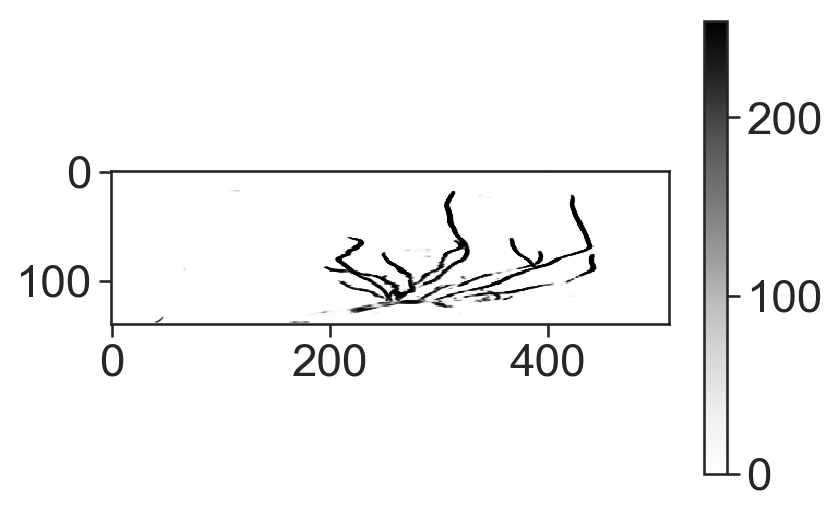

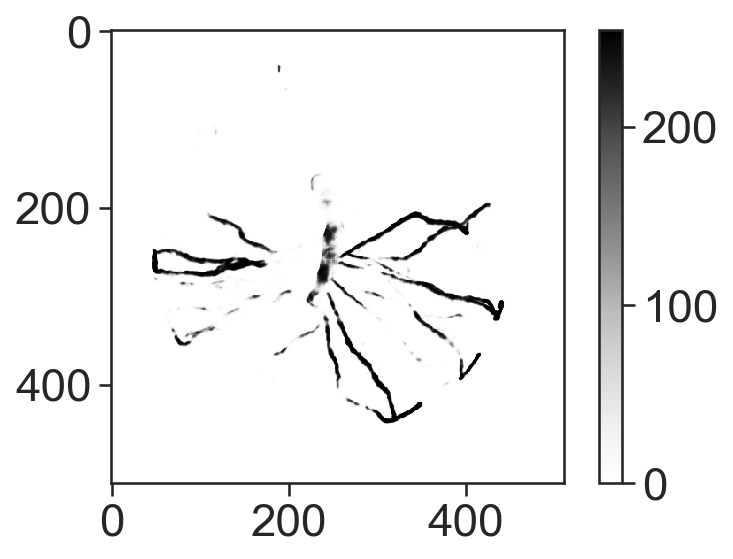

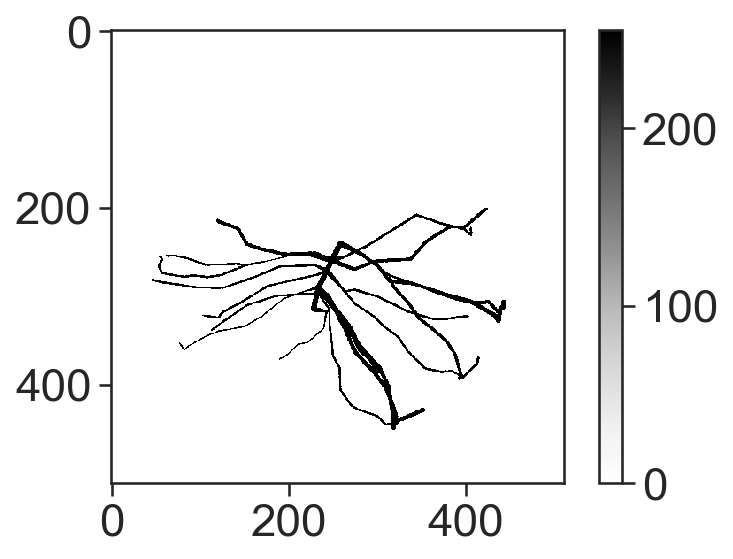


I_Soil_4D_DAP7_mri.npy
(137, 256, 256)


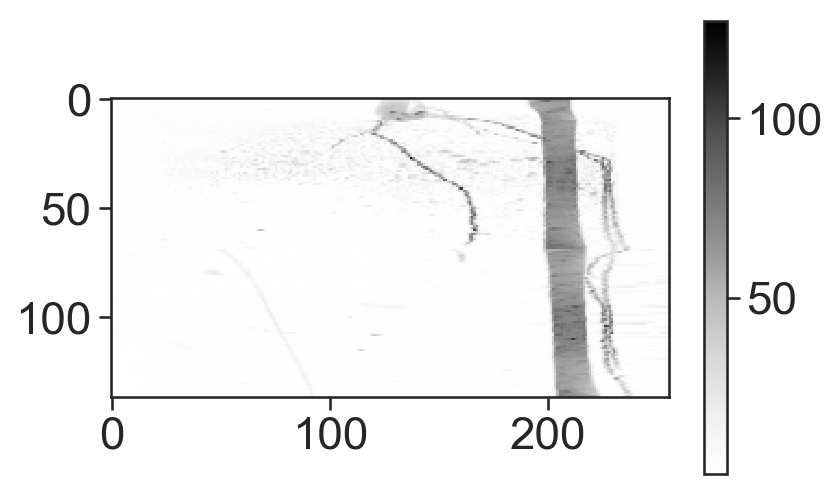

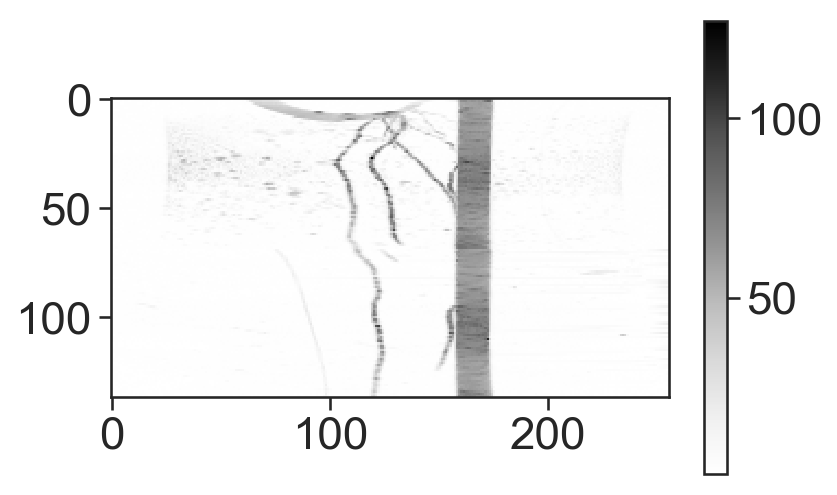

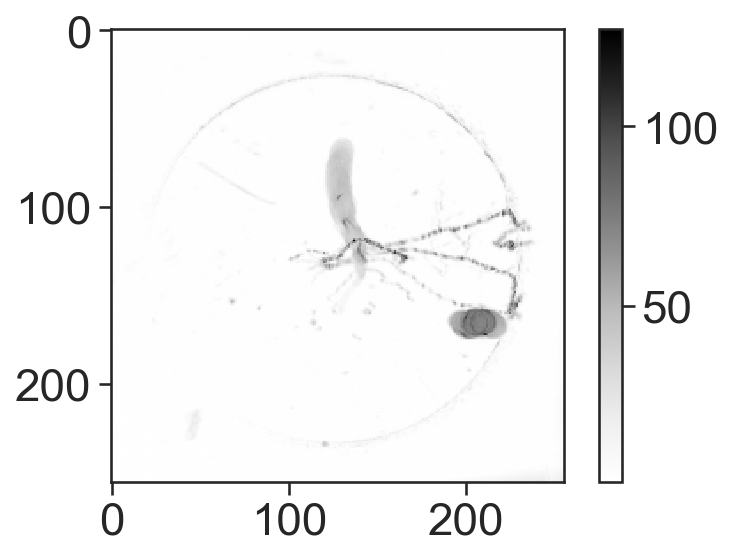

ground truth:


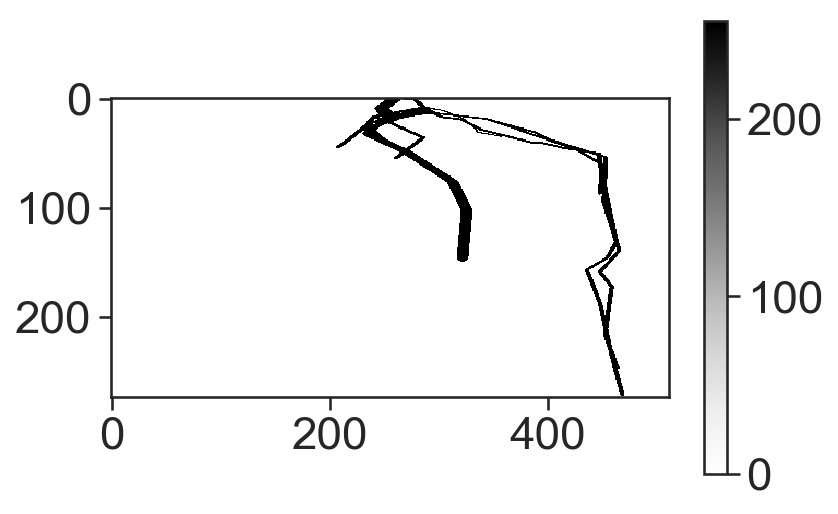

segmentation output:
(274, 512, 512)


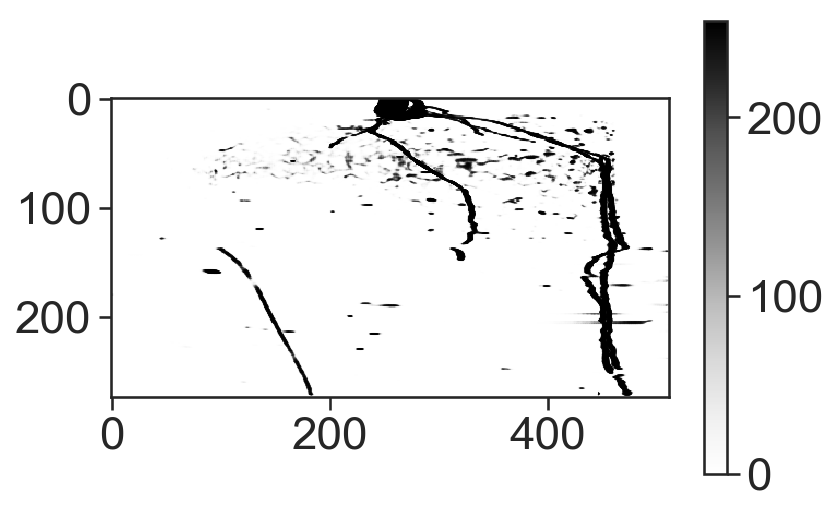

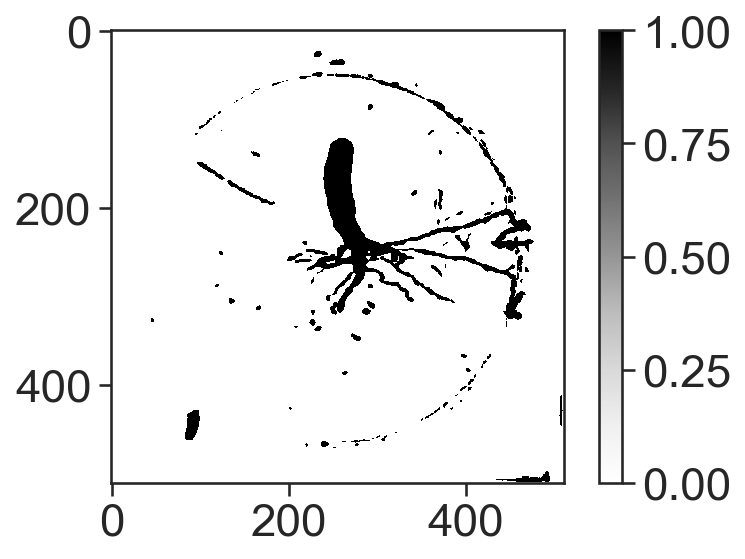

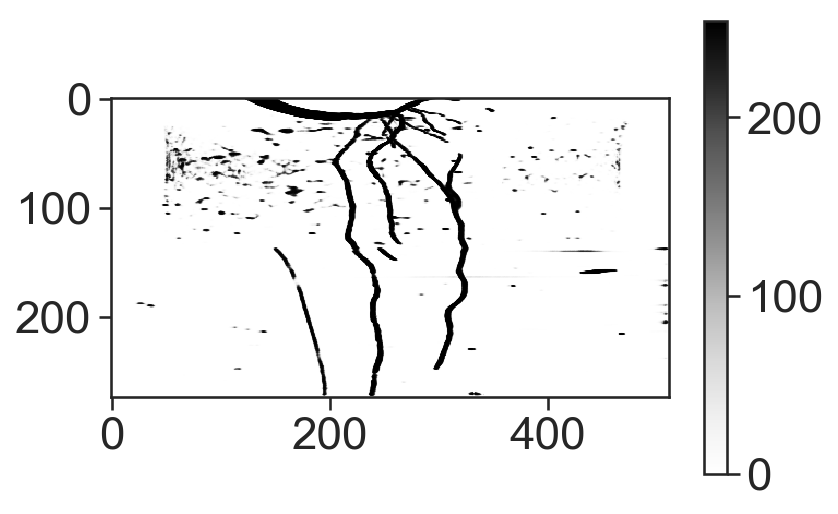

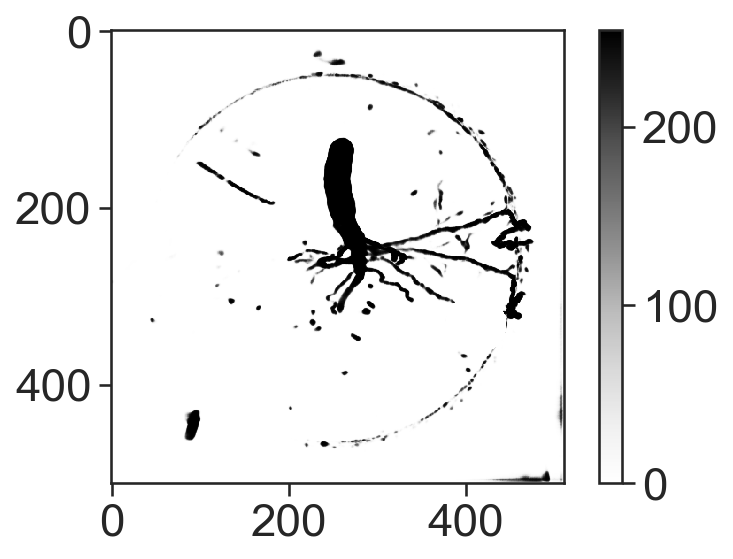

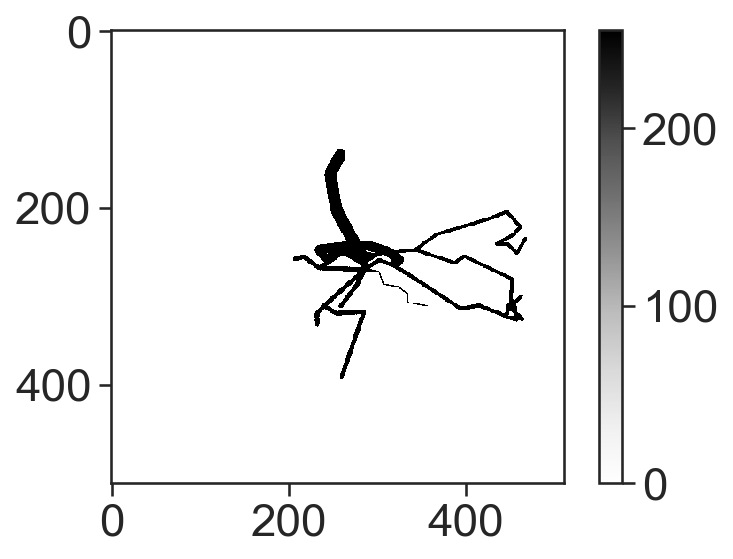

In [137]:
outcrop_overlap = 0
out_dir = join(vis_output_dir, model_name, 'model_{}'.format(training_step), 'outcrop_overlap{}'.format(outcrop_overlap))
gt_dir = join(test_data_dir, 'ground_truth')
probability_threshold = 0.5
sns.set_style('ticks')


for fn in os.listdir(test_data_dir):
    if fn.endswith('.npy'):
        print(fn)
        img = np.load(join(test_data_dir, fn))
        img = np.squeeze(img)
        print(img.shape)
#         plot_one_slice(img, 'x', img.shape[1]//2)
        plot_merged_slices(img, 'x', 0, img.shape[1])
        plot_merged_slices(img, 'y', 0, img.shape[2])
        plot_merged_slices(img, 'z', 0, img.shape[0])
        
        gt = np.load(join(gt_dir, 'gt_{}x_{}'.format(super_res, fn)))
        gt = np.squeeze(gt)
        print('ground truth:')
        plot_merged_slices(gt, 'x', 0, gt.shape[1])
        
        if fn in tube_mask_info:
            # generate the test tube mask for this data
            center_x = tube_mask_info[fn]['center_x'] * super_res
            center_y = tube_mask_info[fn]['center_y'] * super_res
            rad = tube_mask_info[fn]['radius'] * super_res
            tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)
        
        out = np.load(join(out_dir, 'visualized_out_'+fn.strip('.npy')+'.npz'))['arr_0']
        print('segmentation output:')
        print(out.shape)
        # plot_one_slice(out, 'x', out.shape[1]//2)
        if fn in tube_mask_info:
            out[tube_mask] = 0
        plot_merged_slices(out, 'x', 0, out.shape[1])
        plot_merged_slices((out>255*probability_threshold).astype(int), 'z', 0, out.shape[0])
        plot_merged_slices(out, 'y', 0, out.shape[2])
        plot_merged_slices(out, 'z', 0, out.shape[0])
        plot_merged_slices(gt, 'z', 0, gt.shape[0])
        
        print()

I_Soil_1W_DAP7_mri.npy
(131, 256, 256)


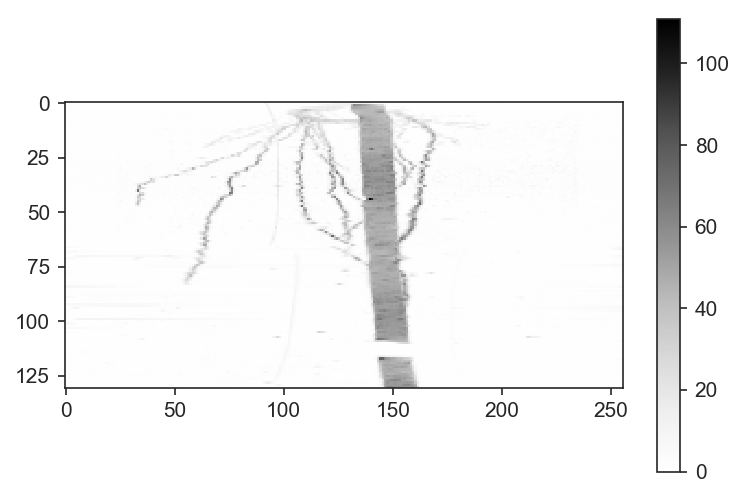

ground truth:


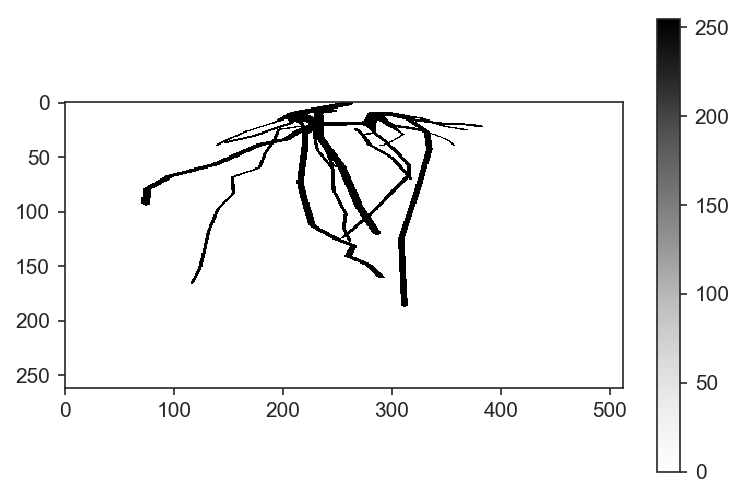

segmentation output:
(262, 512, 512)


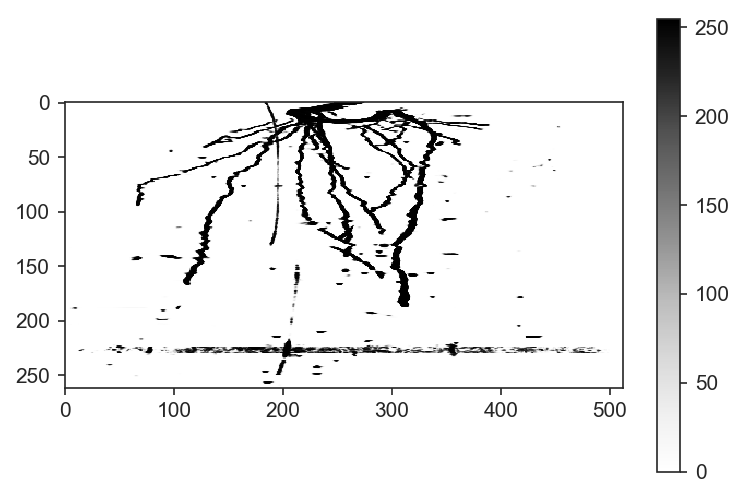

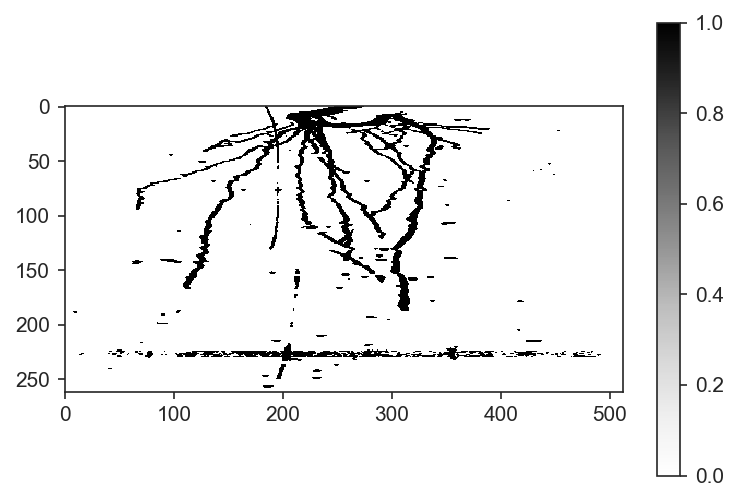

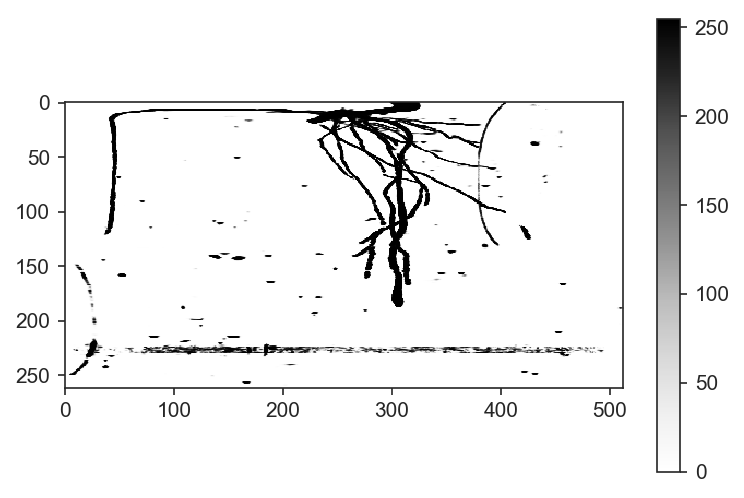


lupine_small_xml_mri.npy
(128, 256, 256)


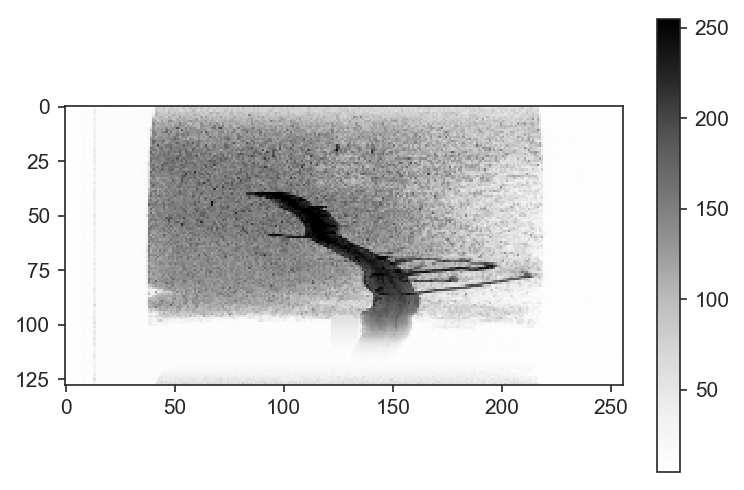

ground truth:


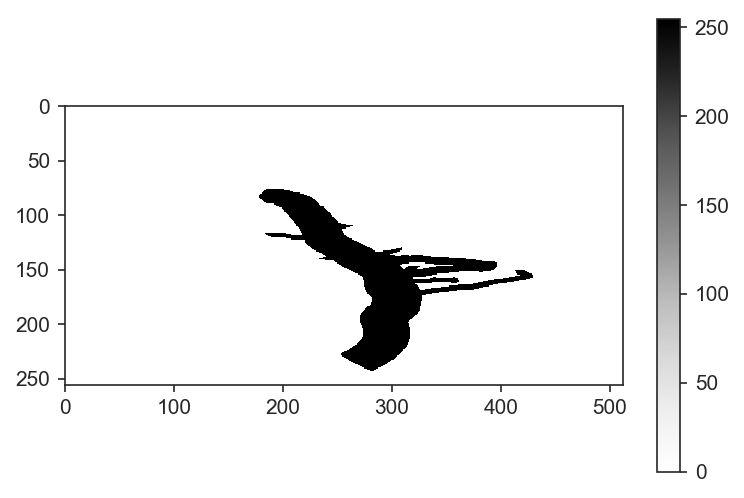

segmentation output:
(256, 512, 512)


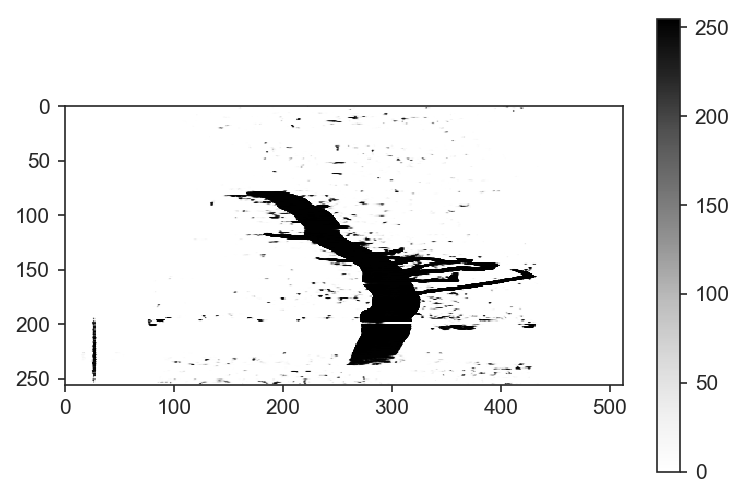

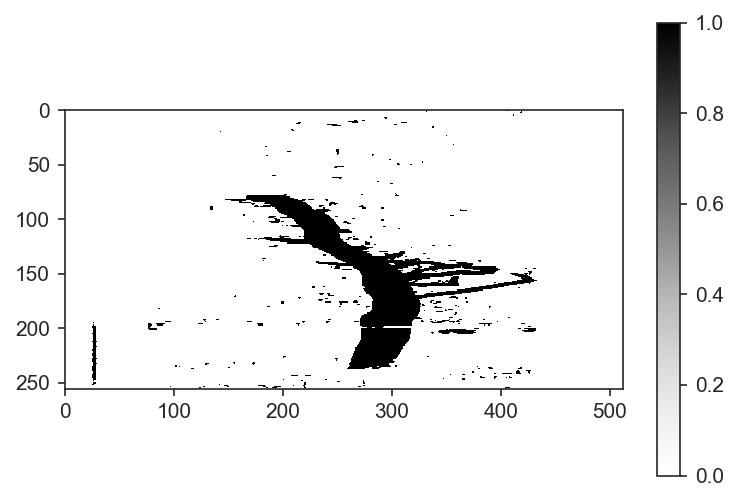

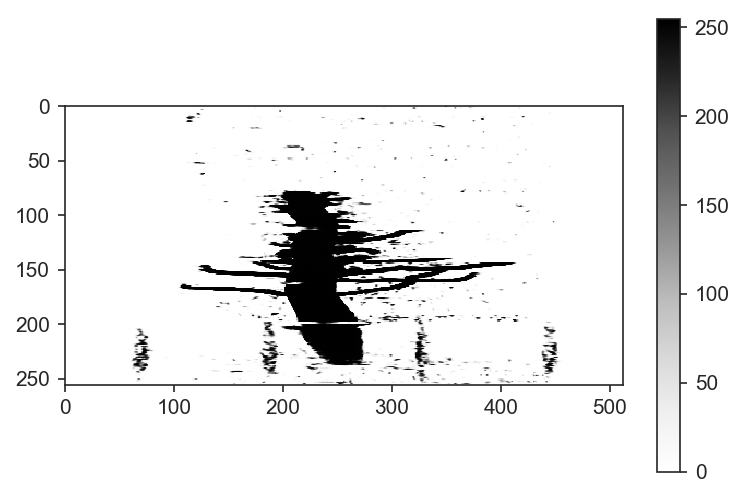


Lupine_22august_mri.npy
(120, 256, 256)


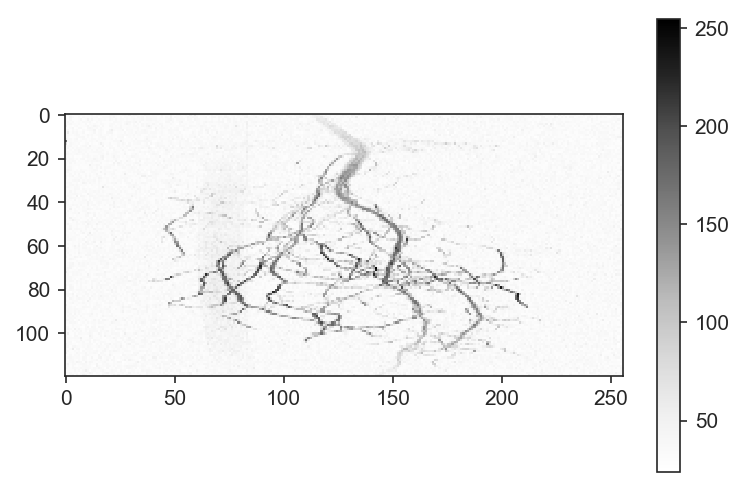

ground truth:


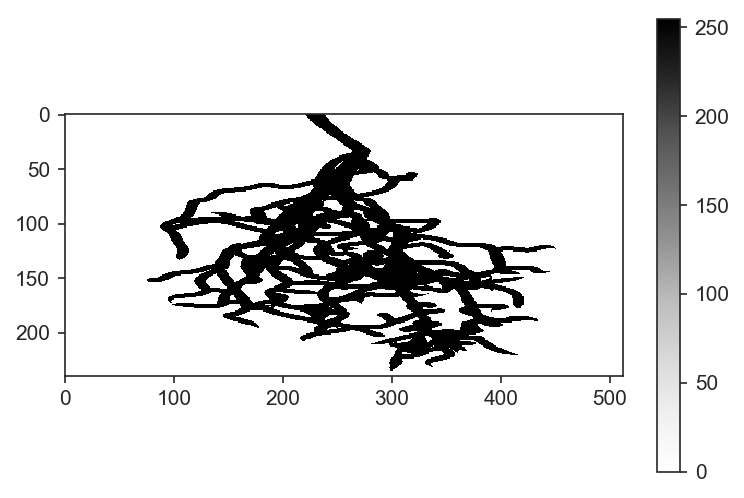

segmentation output:
(240, 512, 512)


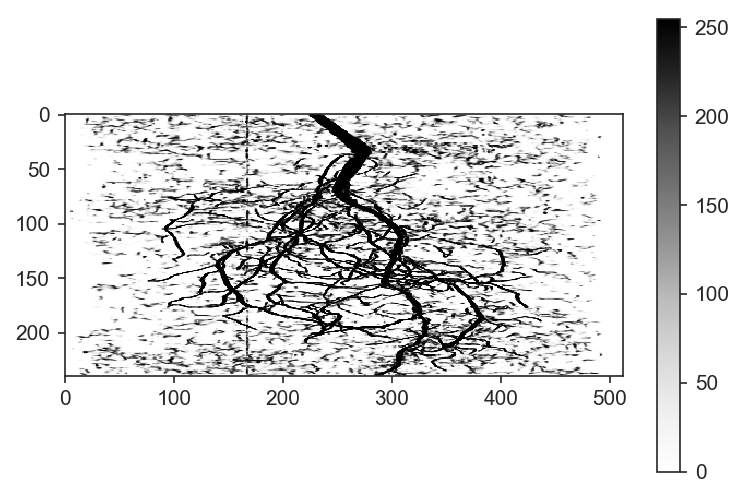

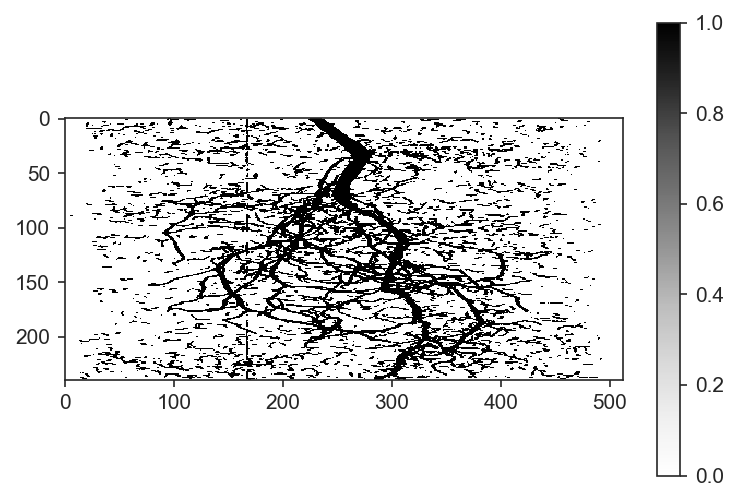

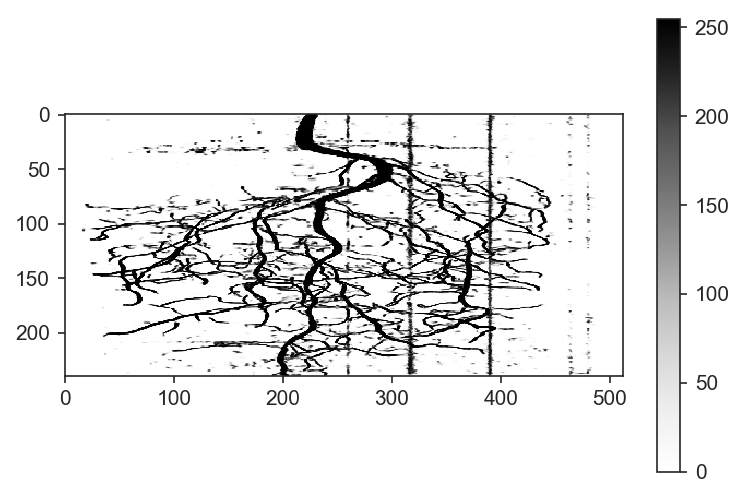


I_Sand_3D_DAP5_mri.npy
(70, 256, 256)


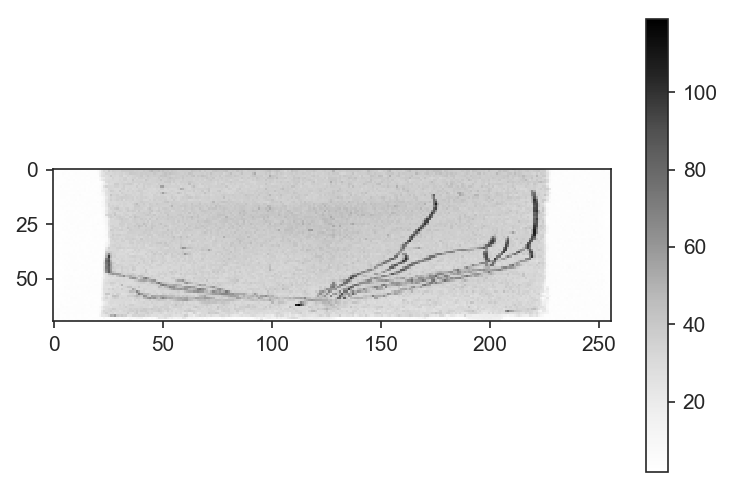

ground truth:


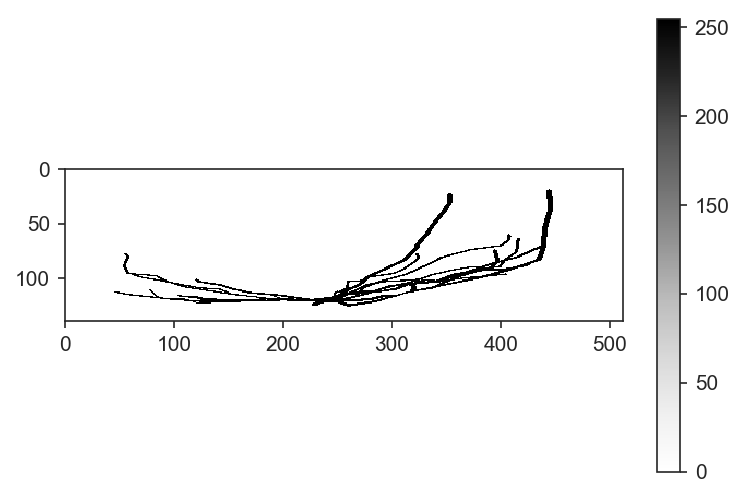

segmentation output:
(140, 512, 512)


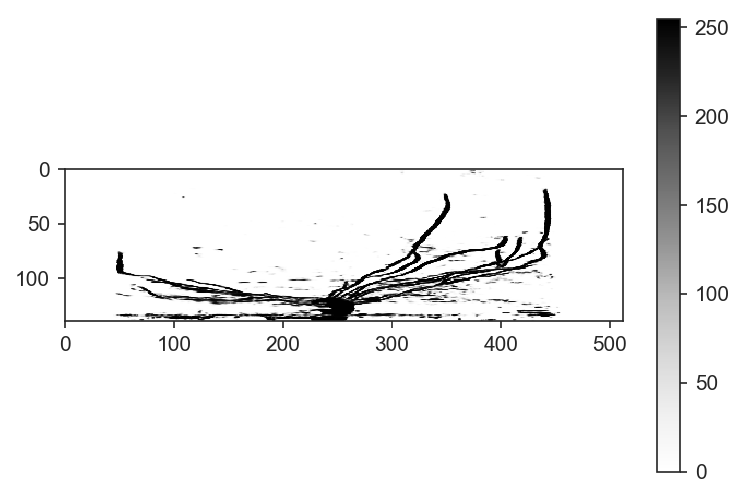

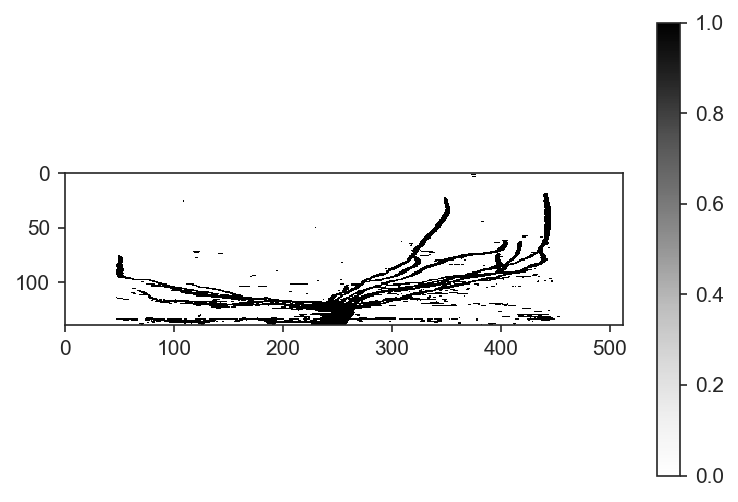

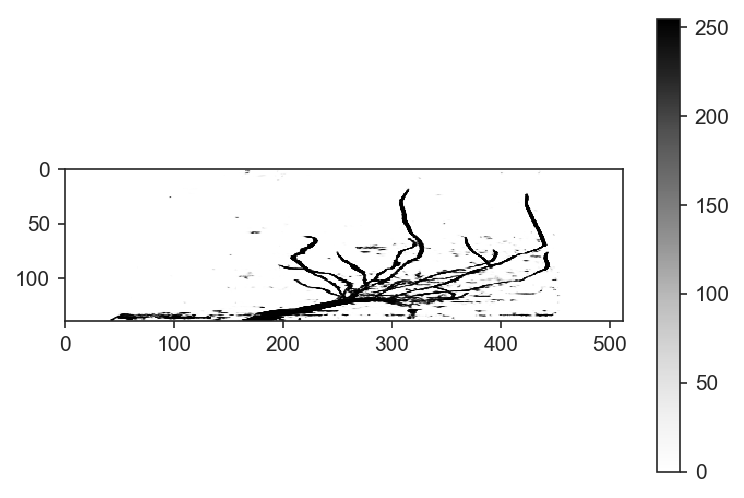


I_Soil_4D_DAP7_mri.npy
(137, 256, 256)


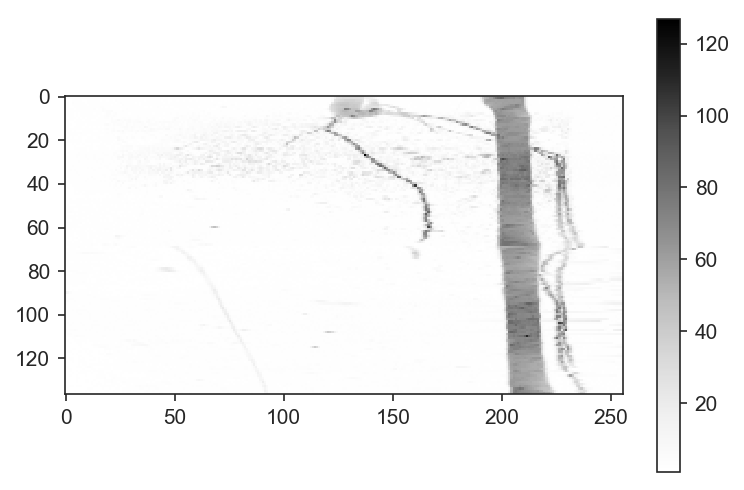

ground truth:


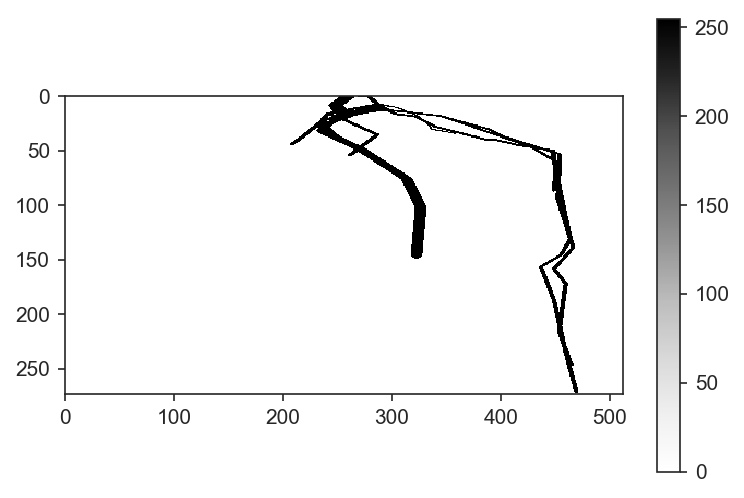

segmentation output:
(274, 512, 512)


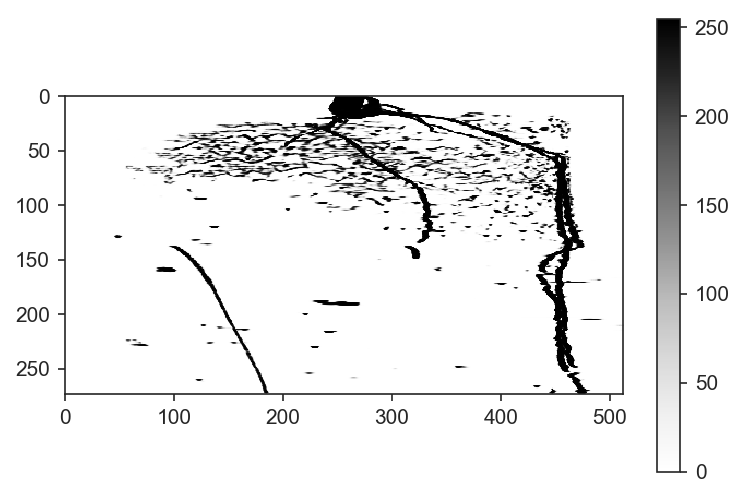

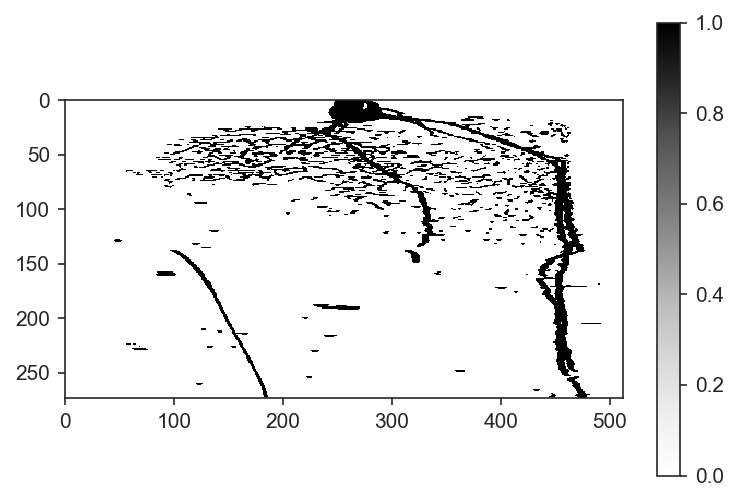

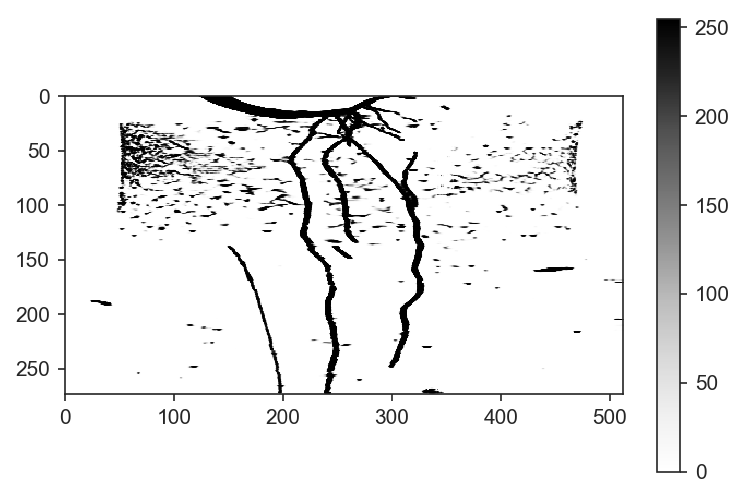

In [5]:
outcrop_overlap = 0
# out_dir = join(vis_output_dir, model_name, 'model_{}'.format(training_step), 'outcrop_overlap{}'.format(outcrop_overlap))
out_dir = '/home/user/zhaoy/Root_MRI/experiments/test_results/oguz_best_model/RefineNet18_l:8_ls:16_cp:0.0_sr:2_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:2000_nl:0_nh:0_nd:1_ng:1_bs:8_f:pca_gi_8_mg_0.01_hd_id_20_09_18'  # for oguz' model
gt_dir = join(test_data_dir, 'ground_truth')
probability_threshold = 0.5
sns.set_style('ticks')

for fn in os.listdir(test_data_dir):
    if fn.endswith('.npy'):
        print(fn)
        img = np.load(join(test_data_dir, fn))
        img = np.squeeze(img)
        print(img.shape)
#         plot_one_slice(img, 'x', img.shape[1]//2)
        plot_merged_slices(img, 'x', 0, img.shape[1])
        #plot_merged_slices(img, 'z', 0, img.shape[0])
        
        gt = np.load(join(gt_dir, 'gt_{}x_{}'.format(super_res, fn)))
        gt = np.squeeze(gt)
        print('ground truth:')
        plot_merged_slices(gt, 'x', 0, gt.shape[1])
        
        if fn in tube_mask_info:
            # generate the test tube mask for this data
            center_x = tube_mask_info[fn]['center_x'] * super_res
            center_y = tube_mask_info[fn]['center_y'] * super_res
            rad = tube_mask_info[fn]['radius'] * super_res
            tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)
        
        out = np.load(join(out_dir, 'visualized_out_'+fn.strip('.npy')+'.npz'))['arr_0']
        print('segmentation output:')
        print(out.shape)
        # plot_one_slice(out, 'x', out.shape[1]//2)
        if fn in tube_mask_info:
            out[tube_mask] = 0
        plot_merged_slices(out, 'x', 0, out.shape[1])
        plot_merged_slices((out>255*probability_threshold).astype(int), 'x', 0, out.shape[1])
        plot_merged_slices(out, 'y', 0, out.shape[2])
        
        print()

### Load the output and the corresponding ground truth

In [167]:
# soil names used to generate the combined test data
soil_names = []
soil_dir = '/home/user/zhaoy/local_dir/mount_data/pure_soil/real_soil_noise'
for fn in os.listdir(soil_dir):
    if fn.endswith('.npy'):
        soil_names.append('_'.join(fn.split('_')[:-2]))
print(soil_names)



['Sand2_new', 'sand_d1', 'sand_unsat_0.39%wc', 'sand_unsat_0.23%wc', 'sand_unsat_0.18%wc', 'Sand1_new', 'sand_d2', 'sand_sat_0.43%wc', 'sand_unsat_0.27%wc', 'sand_unsat_0.34%wc']


In [168]:
# get the dicts of real/virtual test data, with key the test data name, value the gt name
virtual_test_root_gt_dict = {}
real_test_root_gt_dict = {}
for fn in os.listdir(test_data_dir):
    if fn.endswith('.npy'):
        gt_name, is_real = get_gt_filename(fn, super_res, soil_names)
        if is_real:
            real_test_root_gt_dict[fn] = gt_name
        else:
            virtual_test_root_gt_dict[fn] = gt_name
        # print(gt_name)
        # print(np.load(join(gt_dir, gt_name)).shape)
        
print('dict of real test data:', real_test_root_gt_dict)
print('dict of virtual test data:', virtual_test_root_gt_dict)

dict of real test data: {'I_Soil_1W_DAP7_mri.npy': 'gt_2x_I_Soil_1W_DAP7_mri.npy', 'lupine_small_xml_mri.npy': 'gt_2x_lupine_small_xml_mri.npy', 'Lupine_22august_mri.npy': 'gt_2x_Lupine_22august_mri.npy', 'I_Sand_3D_DAP5_mri.npy': 'gt_2x_I_Sand_3D_DAP5_mri.npy', 'I_Soil_4D_DAP7_mri.npy': 'gt_2x_I_Soil_4D_DAP7_mri.npy'}
dict of virtual test data: {}


### for real test data, calculate the F1 score with probability threshold=0.5, different distance tolerances

In [332]:
# # for checking if the calculation is correct
# model_name1 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_24_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_lr1e-4'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_25_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_dontCare'

# out_dir1 = join(vis_output_dir, model_name1, 'model_{}'.format(9), 'outcrop_overlap{}'.format(0))
# out_dir2 = join(vis_output_dir, model_name2, 'model_{}'.format(11), 'outcrop_overlap{}'.format(0))

# out_img1 = np.load(join(out_dir1, 'visualized_out_'+'Lupine_22august_mri.npz'))['arr_0'] 
# out_img2 = np.load(join(out_dir2, 'visualized_out_'+'Lupine_22august_mri.npz'))['arr_0'] 
# gt = np.load(join(gt_dir, real_test_root_gt_dict['Lupine_22august_mri.npy']))
# gt = np.squeeze(gt)

# center_x = tube_mask_info['Lupine_22august_mri.npy']['center_x'] * 2
# center_y = tube_mask_info['Lupine_22august_mri.npy']['center_y'] * 2
# rad = tube_mask_info['Lupine_22august_mri.npy']['radius'] * 2
# tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)
            
# f_score1, precision1, recall1 = distance_tolerant_F_score(out_img1, gt, tolerance=2, 
#                                                                    threshold=0.5, 
#                                                                    f_order=1, dont_care_mask=tube_mask)
            
# f_score2, precision2, recall2 = distance_tolerant_F_score(out_img2, gt, tolerance=2, 
#                                                                    threshold=0.5, 
#                                                                    f_order=1, dont_care_mask=tube_mask)

time used for dilating gt: 0.5740888118743896
time used for dilating pred: 0.6016573905944824
total time used: 2.096388339996338
precision: 0.8815908643433746
recall: 0.4012373135898834

time used for dilating gt: 0.569249153137207
time used for dilating pred: 0.6085050106048584
total time used: 2.121260166168213
precision: 0.7844566686335345
recall: 0.6025626309294918



In [39]:
test_data_dir

'/home/user/zhaoy/local_dir/mount_data/test_data/virtual_data/diff_time_points'

In [169]:
def calc_disTolFscore(out_dir, test_data_dir, super_res, train_data_padding, ignore_test_tube = True, probability_threshold = 0.5, 
                      distance_tolerance_range = np.arange(0,15,2), f_order=1, weight_by_radius=False,
                      radius_histogram=False):
    print('out_dir:', out_dir)
    
    real_data_F_list_dict = {}
    real_data_precision_list_dict = {}
    real_data_recall_list_dict = {}
    
    if radius_histogram:
        radius_gt_list_all = np.zeros(int(max_radius_pivot/radius_bin_size)+1)
        radius_tp_list_all = np.zeros(int(max_radius_pivot/radius_bin_size)+1)

    for input_name in real_test_root_gt_dict:
        output_img = np.load(join(out_dir, 'visualized_out_'+input_name[:-1]+'z'))['arr_0']  # npz file
        gt_dir = join(test_data_dir, 'ground_truth')
        gt = np.load(join(gt_dir, real_test_root_gt_dict[input_name]))
        gt = np.squeeze(gt)
        print(gt.shape)
        print(gt.dtype)
        print(input_name)
        real_data_F_list_dict[input_name] = []
        real_data_precision_list_dict[input_name] = []
        real_data_recall_list_dict[input_name] = []
        # print(output_img.shape)
        # print(gt.shape)
        
        if weight_by_radius:  # load the radius weight matrix
            radius_weight_filename = input_name[:-4]+'_radius.npy'
            radius_weight_matrix = np.load(join(test_data_dir, 'radius_grids', radius_weight_filename))
            # reverse the radius weights so that the thinnest has highest weight
            zero_mask = (radius_weight_matrix==0)
            radius_weight_matrix[zero_mask] = 1  # only for save dividing
            # radius_weight_matrix = radius_weight_matrix.max()-radius_weight_matrix
            radius_weight_matrix = (1/radius_weight_matrix)**2  # power 2
            radius_weight_matrix[zero_mask]=0
            print()
        else:
            radius_weight_matrix = None
            
        if radius_histogram:
            radius_weight_filename = input_name[:-4]+'_radius.npy'
            radius_grid = np.load(join(test_data_dir, 'radius_grids', radius_weight_filename))
            print('max of radius_grid:', radius_grid.max())
        else:
            radius_grid = None

        tube_mask = None
        if ignore_test_tube:
            if input_name in tube_mask_info:
                # generate the test tube mask for this data
                center_x = tube_mask_info[input_name]['center_x'] * super_res
                center_y = tube_mask_info[input_name]['center_y'] * super_res
                rad = tube_mask_info[input_name]['radius'] * super_res
                tube_mask = generate_tube_mask(gt.shape, center_x, center_y, rad)

        # if train_data_padding is odd, shift the gt and tube_mask towards (0,0,0), to match the prediction
        # if even, do nothing
        if train_data_padding%2 != 0:
            gt_shifted = np.zeros(gt.shape).astype(np.uint8)
            gt_shifted[:-1, :-1, :-1] += gt[1:, 1:, 1:]
            gt = gt_shifted
            if tube_mask is not None:
                tube_mask_shifted = np.zeros(tube_mask.shape).astype(np.uint8)
                tube_mask_shifted[:-1, :-1, :-1] += tube_mask[1:, 1:, 1:]
                tube_mask = tube_mask_shifted
            if weight_by_radius:
                # also shift the radius weight matrix
                radius_weight_shifted = np.zeros(radius_weight_matrix.shape).astype(np.float32)
                radius_weight_shifted[:-1, :-1, :-1] += radius_weight_matrix[1:, 1:, 1:]
                radius_weight_matrix = radius_weight_shifted
            if radius_histogram:
                # also shift the radius grid
                radius_grid_shifted = np.zeros(radius_grid.shape).astype(np.float32)
                radius_grid_shifted[:-1, :-1, :-1] += radius_grid[1:, 1:, 1:]
                radius_grid = radius_grid_shifted
        
#         # temp experiment, not used usually
#         gt = gt[50:, :, :]  
#         output_img = output_img[50:, :, :]
#         if tube_mask is not None:
#             tube_mask = tube_mask[50:, :, :]
#         if weight_by_radius:
#             radius_weight_matrix = radius_weight_matrix[50:, :, :]
#         if radius_histogram:
#             radius_grid = radius_grid[50:, :, :]
            
        for t in distance_tolerance_range:
            f_score, precision, recall, \
            radius_tp_list, radius_gt_list = distance_tolerant_F_score(output_img, gt, tolerance=t, 
                                                                   threshold=probability_threshold, 
                                                                   f_order=f_order, dont_care_mask=tube_mask,
                                                                   radius_weight_matrix=radius_weight_matrix,
                                                                   radius_grid=radius_grid)
            real_data_F_list_dict[input_name].append(f_score)
            real_data_precision_list_dict[input_name].append(precision)
            real_data_recall_list_dict[input_name].append(recall)
            
            if radius_histogram:
                radius_gt_list_all += np.array(radius_gt_list)
                radius_tp_list_all += np.array(radius_tp_list)
                print('radius_gt_list_all:', radius_gt_list_all)
                print('radius_tp_list_all:', radius_tp_list_all)
            
    # save the calculated F lists in the model test output directory
    with open(join(out_dir, 'real_data_F_list_dict_probThres{}.pkl'.format(probability_threshold)), 'wb') as f:
        pickle.dump(real_data_F_list_dict, f)
    # at the same time, pickle the distance tolerance range
    with open(join(out_dir, 'distance_tolerance_range.pkl'), 'wb') as f:
        pickle.dump(distance_tolerance_range, f)

    # save the precision lists in the model test output directory
    with open(join(out_dir, 'real_data_precision_list_dict_probThres{}.pkl'.format(probability_threshold)), 'wb') as f:
        pickle.dump(real_data_precision_list_dict, f)
    # save the recall lists in the model test output directory
    with open(join(out_dir, 'real_data_recall_list_dict_probThres{}.pkl'.format(probability_threshold)), 'wb') as f:
        pickle.dump(real_data_recall_list_dict, f)
        
    return real_data_F_list_dict, real_data_precision_list_dict, real_data_recall_list_dict, \
           distance_tolerance_range, radius_tp_list_all/radius_gt_list_all


In [170]:
out_dir

'/home/user/zhaoy/Root_MRI/experiments/test_results/UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1/model_27/outcrop_overlap0'

In [171]:
real_data_F_list_dict, real_data_precision_list_dict, real_data_recall_list_dict, \
           distance_tolerance_range, radius_recall_list_all = calc_disTolFscore(out_dir, test_data_dir, super_res, 
                                                        train_data_padding=0)
#                                                         distance_tolerance_range = np.arange(0,1,2),
#                                                         weight_by_radius=False,
#                                                         radius_histogram = True)  
# for virutal test data: distance_tolerance_range = np.arange(0,1,2))


out_dir: /home/user/zhaoy/Root_MRI/experiments/test_results/UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1/model_27/outcrop_overlap0
(262, 512, 512)
uint8
I_Soil_1W_DAP7_mri.npy
time used for dilating gt: 4.5299530029296875e-06
time used for dilating pred: 1.430511474609375e-06
total time used: 0.9917047023773193
precision: 0.19453365062495667
recall: 0.17248443133398886

time used for dilating gt: 0.6268200874328613
time used for dilating pred: 0.6333065032958984
total time used: 2.243647575378418
precision: 0.4750594921793776
recall: 0.4041502785971813

time used for dilating gt: 0.629401683807373
time used for dilating pred: 0.630624532699585
total time used: 2.2445929050445557
precision: 0.6897858281542407
recall: 0.6139380530973452

time used for dilating gt: 0.6308603286743164
time used for dilating pr

UnboundLocalError: local variable 'radius_tp_list_all' referenced before assignment

In [278]:

x

['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-']

In [49]:
# radius_recall_list_all_bothTime
# radius_recall_list_all_earlierTime = radius_recall_list_all
# radius_recall_list_all_bothTime = radius_recall_list_all

In [66]:
# generate the dataframe to plot the histogram with sns
radius_range_lower=np.arange(0, max_radius_pivot+radius_bin_size, radius_bin_size)
radius_range_higher=radius_range_lower[1:]
radius_range = []
for i in range(len(radius_range_lower)-1):
    radius_range.append('{} - {}'.format(radius_range_lower[i], radius_range_higher[i]))    
radius_range.append('> {}'.format(radius_range_lower[-1]))

assert len(radius_range) == len(radius_recall_list_all_bothTime)
assert len(radius_range) == len(radius_recall_list_all_earlierTime)

dict_to_plot = {'recall':[], 'Later time point':[], 'radius':[]}

# Model with the earlier time point
dict_to_plot['recall'].extend(radius_recall_list_all_earlierTime)
dict_to_plot['Later time point'].extend(['without' for _ in range(len(radius_range))])
dict_to_plot['radius'].extend(radius_range)

# Model with both time points
dict_to_plot['recall'].extend(radius_recall_list_all_bothTime)
dict_to_plot['Later time point'].extend(['with' for _ in range(len(radius_range))])
dict_to_plot['radius'].extend(radius_range)

df = pd.DataFrame(data=dict_to_plot) 
df

recall Later time point radius
0  0.481782          without  0 - 1
1  0.958315          without    > 1
2  0.567689             with  0 - 1
3  0.950928             with    > 1

<Figure size 720x480 with 0 Axes>

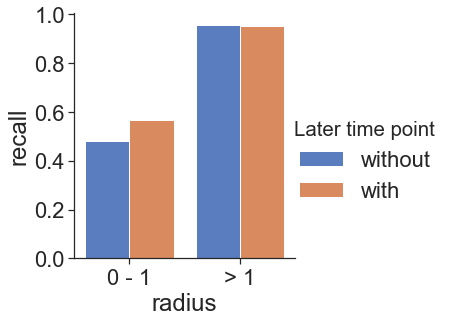

In [68]:
with sns.plotting_context("notebook", font_scale=2):
    fig = plt.figure(dpi=120)
    g = sns.catplot(x="radius", y="recall", hue="Later time point", data=df,
                    kind="bar", palette="muted", aspect=1)
#     plt.savefig(join('thesis_figures', 'recall_for_diffRad_earlierVSboth_2bins_bigFont'), dpi=fig.dpi)


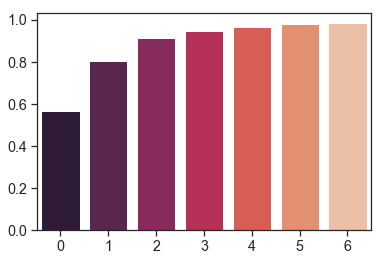

In [258]:
sns.barplot(x=np.arange(0, max_radius_pivot+radius_bin_size, radius_bin_size), 
            y=radius_recall_list_all, palette="rocket")

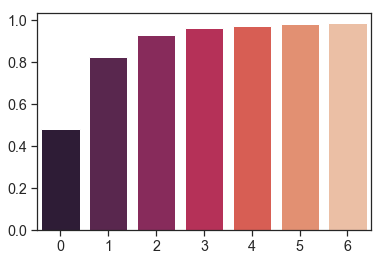

In [263]:
sns.barplot(x=np.arange(0, max_radius_pivot+radius_bin_size, radius_bin_size), 
            y=radius_recall_list_all, palette="rocket")

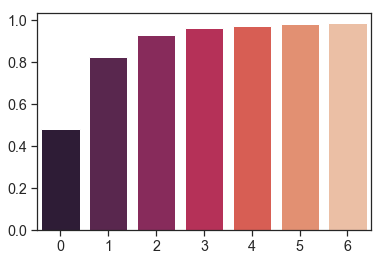

In [230]:
sns.barplot(x=np.arange(0, max_radius_pivot+radius_bin_size, radius_bin_size), 
            y=radius_recall_list_all, palette="rocket")

In [ ]:
range(0, max_radius_pivot+radius_bin_size, radius_bin_size)

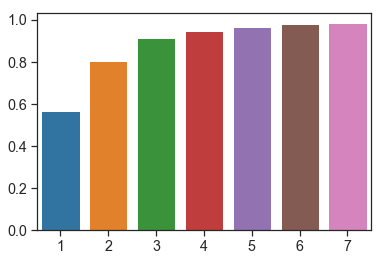

In [212]:
sns.barplot(x=np.arange(1,8), y=radius_recall_list_all)

In [24]:
# # test on individual data to verify if the F score calculation is correct
# pred = np.load(join(out_dir, 'visualized_out_imitate_lupineSmall_785525_earlier_mri.npz'))['arr_0']
# pred = pred/255
# pred = (pred>=0.5).astype(np.uint8)
# # pred_shifted = np.zeros(pred.shape).astype(np.uint8)
# # pred_shifted[1:,1:,1:] += pred[:-1, :-1, :-1]
# # np.savez('pred_shifted.npz', pred_shifted)

# # print(pred.max())
# gt = np.load(join(gt_dir, 'gt_2x_imitate_lupineSmall_785525_earlier_mri.npy'))
# gt = np.squeeze(gt)
# gt = (gt/255).astype(np.uint8)

# gt_shifted = np.zeros(gt.shape).astype(np.uint8)
# gt_shifted[:-1, :-1, :-1] += gt[1:, 1:, 1:]
# gt = gt_shifted
# tp = (gt*pred).sum()
# precision = tp/pred.sum()
# recall = tp/gt.sum()
# print(precision)
# print(recall)
# f1 = 2*precision*recall/(precision+recall)
# print(f1)


0.9547136579551317
0.9601542301464471
0.9574262151035464


In [114]:
def plot_avg_fscore(F_list_dict_list, x_list, model_name_list, 
                    fig_name='', title=None, legend_name='', legend_off=False):
    # plot the average F score of different test data under some changing conditions (such as distance tolerances)
    # F_list_dict: key is input data name, value is the F score list of it
    assert len(F_list_dict_list) == len(model_name_list)
    
    fig = plt.figure(dpi=120)  
    sns.set_context("notebook", font_scale=1.3)
    # sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
    sns.set_style('darkgrid', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})
    
    dict_to_plot = {'distance tolerance':[], 'F1 score':[], legend_name:[], 'test data': []}
    for i in range(len(F_list_dict_list)):
        F_list_dict = F_list_dict_list[i]
        model_name = model_name_list[i]
        for input_name in F_list_dict:
            dict_to_plot['F1 score'].extend(F_list_dict[input_name])
            dict_to_plot['distance tolerance'].extend(x_list)
            dict_to_plot[legend_name].extend([model_name for _ in range(len(x_list))])
            dict_to_plot['test data'].extend([input_name[:-8] for _ in range(len(x_list))])
    
    df = pd.DataFrame(data=dict_to_plot)   
    df_to_plot = df
#     df_to_plot = df.loc[df['test data'] == 'Lupine_22august_mri.npy']
    if legend_off:
        ax = sns.catplot(x='distance tolerance', y='F1 score', hue=legend_name, data=df_to_plot, kind="point", 
                         marker="o", aspect=1.3, capsize=.2, legend=False)  # ci=95
    else:
        ax = sns.catplot(x='distance tolerance', y='F1 score', hue=legend_name, data=df_to_plot, kind="point", 
                         marker="o", aspect=1.3, capsize=.2)  # ci=95

    # for l in ax.ax.lines:
        # print(l.get_linewidth())
        # plt.setp(l,linewidth=3)  # 2
        
    # adjust legend location
    leg = ax._legend
    leg.set_bbox_to_anchor([1,0.27])
    
    # set title
    ax.set_titles('lalala')
        
    plt.ylim(-0.05, 1.05)
    #plt.savefig(join('thesis_figures', fig_name), dpi=fig.dpi)
    plt.show()


def generate_df_for_plotting(F_list_dict_list, x_list, model_name_list, legend_name='', 
                             y_label='F1 score'):
    # F_list_dict: key is input data name, value is the F score list of it
    assert len(F_list_dict_list) == len(model_name_list)
    
    dict_to_plot = {'distance tolerance':[], y_label:[], legend_name:[], 'test data': []}
    for i in range(len(F_list_dict_list)):
        F_list_dict = F_list_dict_list[i]
        model_name = model_name_list[i]
        for input_name in F_list_dict:
            dict_to_plot[y_label].extend(F_list_dict[input_name])
            dict_to_plot['distance tolerance'].extend(x_list)
            dict_to_plot[legend_name].extend([model_name for _ in range(len(x_list))])
            dict_to_plot['test data'].extend([input_name[:-8] for _ in range(len(x_list))])
    
    df = pd.DataFrame(data=dict_to_plot) 
    return df
    
    
def plot_fscore_for_each_data(F_list_dict, x_list, title):
    # plot the F score of each data
    
    for input_name in F_list_dict:
        plt.figure(dpi=120)
        f_list = F_list_dict[input_name]
        plt.plot(np.arange(len(f_list)), f_list, marker='o')
        plt.xticks(np.arange(len(f_list)), x_list)
        plt.title(input_name+'\n'+title)
    plt.show()

In [ ]:
# Plot the averaged F1 score for different distance tolerances

plot_avg_fscore([real_data_F_list_dict], distance_tolerance_range, [''], title='Average F scores for different distance tolerances', legend_off=True, fig_name='F_original_dataset_diff_test_data')


## Load model results for plotting

In [186]:
def load_metrics_lists(model_name, model_index, outcrop_overlap, out_dir=None, older_version=False):
    if out_dir is None:
        out_dir = join(vis_output_dir, model_name, 'model_{}'.format(model_index), 
                       'outcrop_overlap{}'.format(outcrop_overlap))
    with open(join(out_dir, 'real_data_F_list_dict_probThres{}.pkl'.format(0.5)), 'rb') as f:
        real_data_F_list_dict = pickle.load(f)
    with open(join(out_dir, 'distance_tolerance_range.pkl'), 'rb') as f:
        distance_tolerance_range = pickle.load(f)

    if older_version:  # for older results, prediction and recall are not recorded
        real_data_precision_list_dict = []
        real_data_recall_list_dict = []
    else:
        with open(join(out_dir, 'real_data_precision_list_dict_probThres{}.pkl'.format(0.5)), 'rb') as f:
            real_data_precision_list_dict = pickle.load(f)
        with open(join(out_dir, 'real_data_recall_list_dict_probThres{}.pkl'.format(0.5)), 'rb') as f:
            real_data_recall_list_dict = pickle.load(f)

    return real_data_F_list_dict, distance_tolerance_range, \
           real_data_precision_list_dict, real_data_recall_list_dict

# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_25_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_dontCare'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_31_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_uniSamp_distToCenterAxis'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_28_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_earlierTimeOnly'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_28_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_earlierTimeOnly'  # 11
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_03_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_shuffledFixedCropTrain_uniSamp_depthArray_zFlipCorrect'  # 16
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_03_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_shuffledFixedCropTrain_uniSamp_distToCenterAxis_zflipCorrect'  # 7
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x10.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_05_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_fixCropTrain_shuffleCrops_uniSamp_rootWeight10'  # 13
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_15_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLossWeight10_lossRecording'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_22_10_19_3DUNet_trainOnNonCombinedOnly_validateOnCrops_notFixedCropTrain_uniSamp_lr1e-4' # 20
model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1'  # 14


real_data_F_list_dict, distance_tolerance_range, \
real_data_precision_list_dict, real_data_recall_list_dict = load_metrics_lists(model_name, 27, 0)
                                                                               # older_version=True)
                                                                               # out_dir='/home/user/zhaoy/Root_MRI/experiments/test_results/UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_28_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_earlierTimeOnly/model_11/outcrop_overlap0/radius_weighted_power1')
                                                                               # out_dir='/home/user/zhaoy/Root_MRI/experiments/test_results/oguz_best_model/RefineNet18_l:8_ls:16_cp:0.0_sr:2_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:2000_nl:0_nh:0_nd:1_ng:1_bs:8_f:pca_gi_8_mg_0.01_hd_id_20_09_18')

model_name2='UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_24_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_lr1e-4'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_addLaterTimePoint_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_29_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_earlierPlusLaterTime'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_addLaterTimePoint_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_29_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_earlierPlusLaterTime'  # 11
real_data_F_list_dict2, distance_tolerance_range2, \
real_data_precision_list_dict2, real_data_recall_list_dict2 = load_metrics_lists(model_name2, 9, 0)
                                                                                 # out_dir='/home/user/zhaoy/Root_MRI/experiments/test_results/UNet_3D_noPadding_BNbeforeReLU_addLaterTimePoint_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_29_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_earlierPlusLaterTime/model_11/outcrop_overlap0/radius_weighted_power1')
                                                                                 #out_dir='/home/user/zhaoy/Root_MRI/experiments/test_results/oguz_best_model/RefineNet18_l:8_ls:16_cp:0.0_sr:2_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:2000_nl:0_nh:0_nd:1_ng:1_bs:8_f:pca_gi_8_mg_0.01_hd_id_20_09_18')

assert distance_tolerance_range.all() == distance_tolerance_range2.all()

In [ ]:
# compare 2 models
plot_avg_fscore([real_data_F_list_dict2, real_data_F_list_dict], distance_tolerance_range, 
                ['uniform sampling', 'importance sampling'], 
                legend_name='', legend_off=False,
                fig_name='distance_tol_F_is_VS_us')


In [116]:
real_data_F_list_dict2

{'I_Soil_1W_DAP7_mri.npy': [0.18657306033996252,
  0.43426653146859767,
  0.643637155827373,
  0.7883287243270284,
  0.8780159236437366,
  0.9298437294269466,
  0.9576495152305923,
  0.9729260722914154],
 'lupine_small_xml_mri.npy': [0.7577955590059372,
  0.8690408971964795,
  0.9155564814216884,
  0.9426585998940684,
  0.9600432106069562,
  0.9712039650141282,
  0.9791192691448443,
  0.9846448757621047],
 'Lupine_22august_mri.npy': [0.2282314720976476,
  0.5514801688631483,
  0.7564762469775916,
  0.8651317334970017,
  0.9192465509734992,
  0.9455419201661038,
  0.9582327836507872,
  0.966028164793529],
 'I_Sand_3D_DAP5_mri.npy': [0.12617709899501464,
  0.3905244610983104,
  0.5601062952047147,
  0.648915532776788,
  0.6949824547700721,
  0.7249246537626457,
  0.7485590021261801,
  0.7676120086653184],
 'I_Soil_4D_DAP7_mri.npy': [0.27858374983413686,
  0.5075237550149878,
  0.6632693214723312,
  0.7720287105302275,
  0.8436004289028423,
  0.888185741842616,
  0.9143383608200897,
  0.9

In [189]:
legend_name='Increase loss on edges'  
#"Later time point", 'Model', 'Voxel depth info', 'Distance to central axis'， 'Root weight', 'Gradient difference loss'
y_label='Precision'  # Recall, Precision, F1 score
model_id_list = ['no', 'yes'] # ['RefineNet', "3D U-Net"], ['with', 'without']， ['1', '10'], ['original dataset', 'improved dataset']

# df = generate_df_for_plotting([real_data_F_list_dict2], 
#                                    distance_tolerance_range, 
#                                    [''], legend_name='')

# df = generate_df_for_plotting([real_data_F_list_dict2, real_data_F_list_dict], 
#                                    distance_tolerance_range, 
#                                    model_id_list, legend_name=legend_name, y_label=y_label)

# df = generate_df_for_plotting([real_data_recall_list_dict2, real_data_recall_list_dict], 
#                                    distance_tolerance_range, 
#                                    model_id_list, legend_name=legend_name, y_label=y_label)

df = generate_df_for_plotting([real_data_precision_list_dict2, real_data_precision_list_dict], 
                                   distance_tolerance_range, 
                                   model_id_list, legend_name=legend_name, y_label=y_label)

# df_plot = df.loc[df['test data'] == 'Lupine_22august']
# df_plot = df.loc[df['Later time point'] == 'yes']
df_plot = df
df['test data'].unique()

array(['I_Soil_1W_DAP7', 'lupine_small_xml', 'Lupine_22august',
       'I_Sand_3D_DAP5', 'I_Soil_4D_DAP7'], dtype=object)

<Figure size 720x480 with 0 Axes>

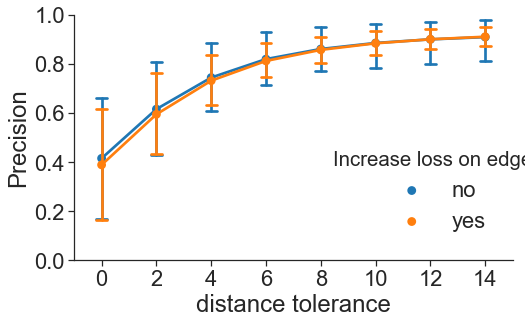

In [190]:
# for real test data
fig = plt.figure(dpi=120)  
sns.set_context("notebook", font_scale=2)
# sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style('ticks', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})  # darkgrid


ax = sns.catplot(x='distance tolerance', y=y_label, hue=legend_name, data=df_plot, kind="point", 
                 marker="o", aspect=1.6, capsize=.2, legend=True)  # ci=95

# for l in ax.ax.lines:
    # print(l.get_linewidth())
    # plt.setp(l,linewidth=3)  # 2

# adjust legend location
leg = ax._legend
leg.set_bbox_to_anchor([0.7,0.37])

# set title
# plt.title('All test data')

plt.ylim(0, 1)
# plt.savefig(join('thesis_figures', 'originalVSimprovedData_F1_2'), dpi=fig.dpi)
plt.show()

In [180]:
# generate the dataframe for plotting for the results on virtual test data only
F_list_dict_list = [real_data_F_list_dict, real_data_F_list_dict2]
recall_list_dict_list = [real_data_recall_list_dict, real_data_recall_list_dict2]
precision_list_dict_list = [real_data_precision_list_dict, real_data_precision_list_dict2]
model_name_list = ["without", 'with']

dict_to_plot = {'value':[], '':[], 'test data': [], "Later time point":[]}
for i in range(len(F_list_dict_list)):
    F_list_dict = F_list_dict_list[i]
    recall_list_dict = recall_list_dict_list[i]
    precision_list_dict = precision_list_dict_list[i]
    model_name = model_name_list[i]
    for input_name in F_list_dict:
        dict_to_plot['value'].extend(F_list_dict[input_name])
        dict_to_plot['Later time point'].extend([model_name])
        dict_to_plot['test data'].extend([input_name[:-8]])
        dict_to_plot[''].extend(['F1 score'])
        
        dict_to_plot['value'].extend(recall_list_dict[input_name])
        dict_to_plot['Later time point'].extend([model_name])
        dict_to_plot['test data'].extend([input_name[:-8]])
        dict_to_plot[''].extend(['recall'])
        
        dict_to_plot['value'].extend(precision_list_dict[input_name])
        dict_to_plot['Later time point'].extend([model_name])
        dict_to_plot['test data'].extend([input_name[:-8]])
        dict_to_plot[''].extend(['precision'])

df = pd.DataFrame(data=dict_to_plot) 
df_plot = df
# df_plot
df['test data'].unique()

array(['715310_earlier', '679320_earlier',
       'imitate_lupineSmall_785525_earlier',
       'imitate_lupineSmall_241385_earlier',
       'imitate_lupine22_919191_earlier',
       'imitate_lupine22_103409_earlier'], dtype=object)

<Figure size 720x480 with 0 Axes>

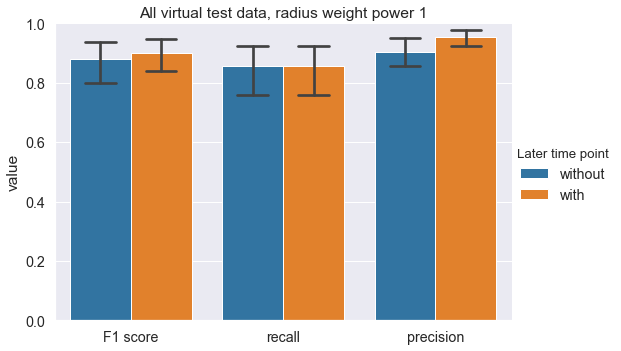

In [182]:
# # for virtual test data
# df_plot = df.loc[df['test data'] == 'imitate_lupine22_103409_earlier']

fig = plt.figure(dpi=120)  
sns.set_context("notebook", font_scale=1.3)
# sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style('darkgrid', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})


ax = sns.catplot(x='', y='value', hue='Later time point', data=df_plot, kind="bar", capsize=.2, aspect=1.5)  # ci=95

# for l in ax.ax.lines:
    # print(l.get_linewidth())
    # plt.setp(l,linewidth=3)  # 2

# # adjust legend location
# leg = ax._legend
# leg.set_bbox_to_anchor([1,0.28])

# set title
plt.title('All virtual test data, radius weight power 1')  # All test data

plt.ylim(0, 1)
# plt.savefig(join('thesis_figures', 'virtual_test_data_f1_rec_prec_multi_timepoins_radiusWeightPower1'), dpi=fig.dpi)
plt.show()

In [427]:
real_test_root_gt_dict

{'I_Soil_1W_DAP7_mri.npy': 'gt_2x_I_Soil_1W_DAP7_mri.npy',
 'lupine_small_xml_mri.npy': 'gt_2x_lupine_small_xml_mri.npy',
 'Lupine_22august_mri.npy': 'gt_2x_Lupine_22august_mri.npy',
 'I_Sand_3D_DAP5_mri.npy': 'gt_2x_I_Sand_3D_DAP5_mri.npy',
 'I_Soil_4D_DAP7_mri.npy': 'gt_2x_I_Soil_4D_DAP7_mri.npy'}

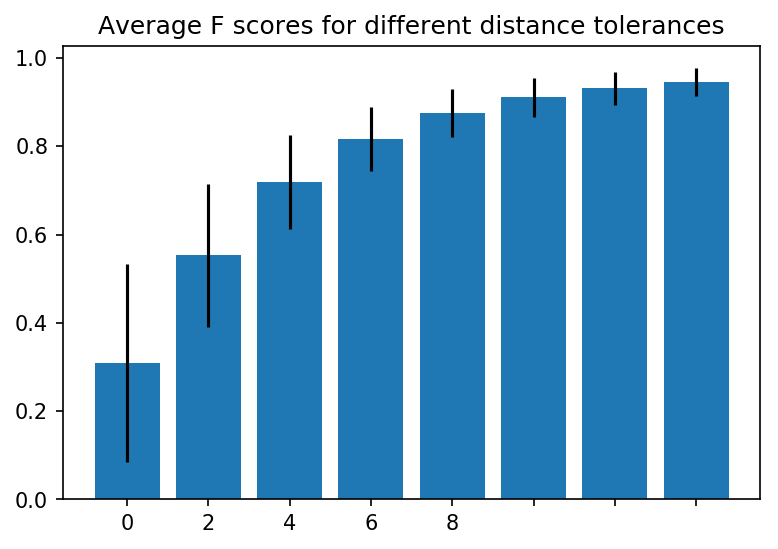

In [51]:
plot_avg_fscore(real_data_F_list_dict, x_list=distance_tolerance_range, title='Average F scores for different distance tolerances')


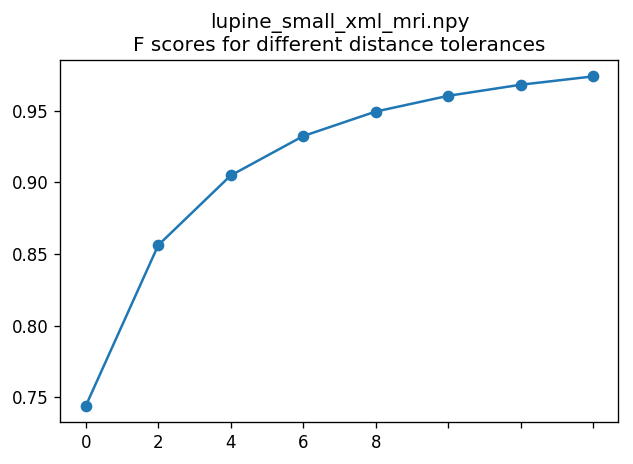

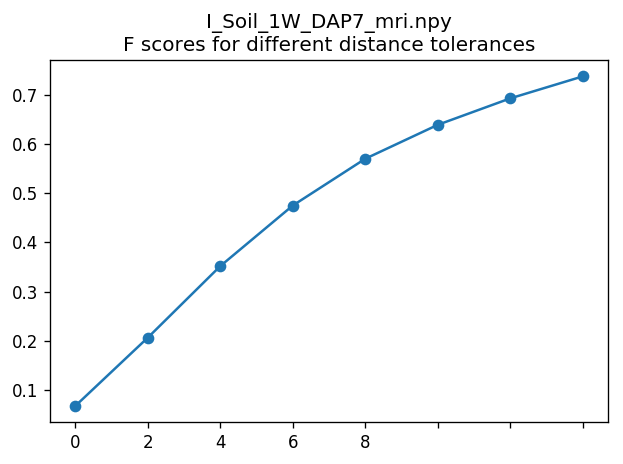

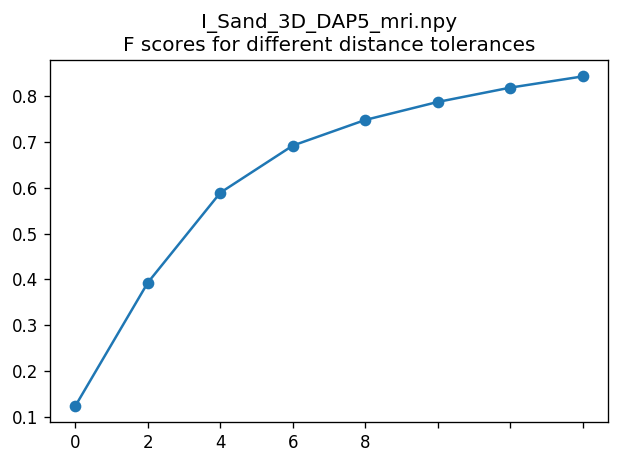

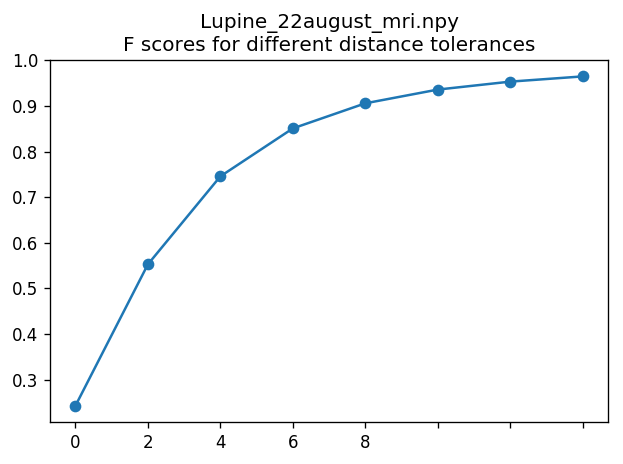

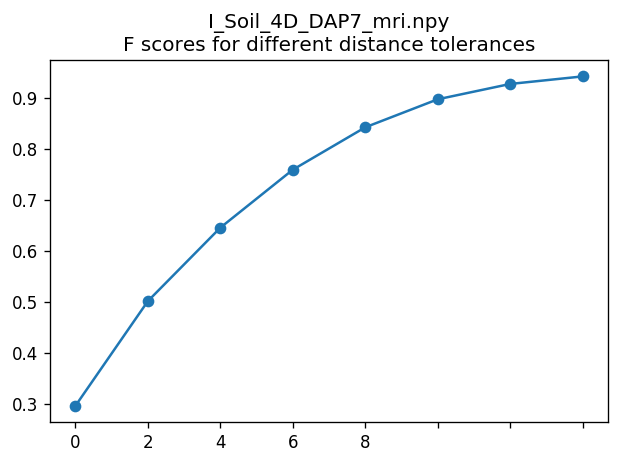

In [43]:
# Plot the F1 list for each input data

plot_fscore_for_each_data(real_data_F_list_dict, x_list=distance_tolerance_range, title='F scores for different distance tolerances')


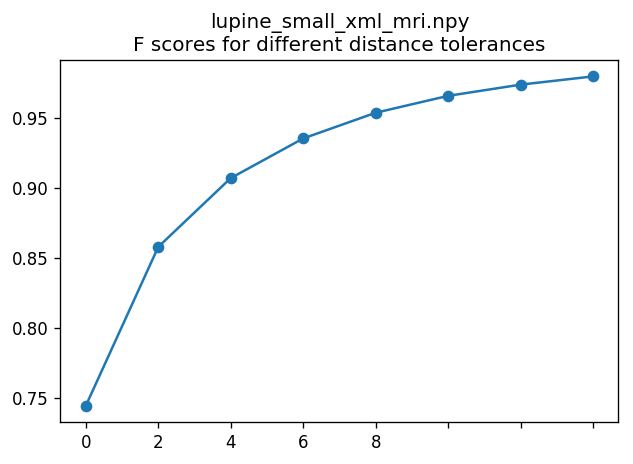

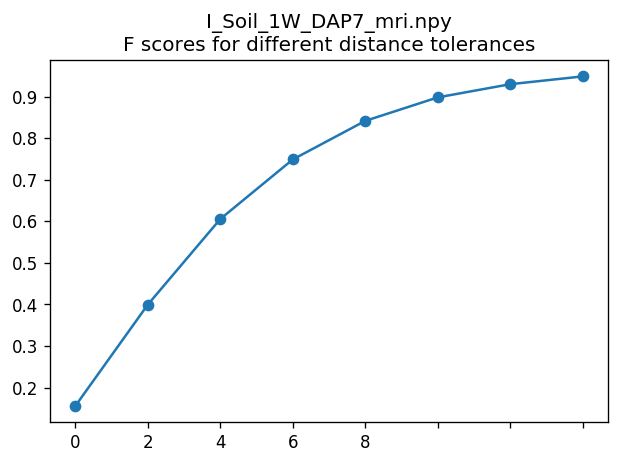

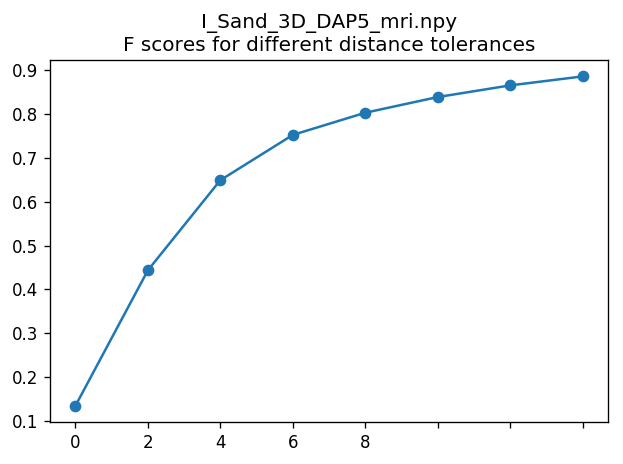

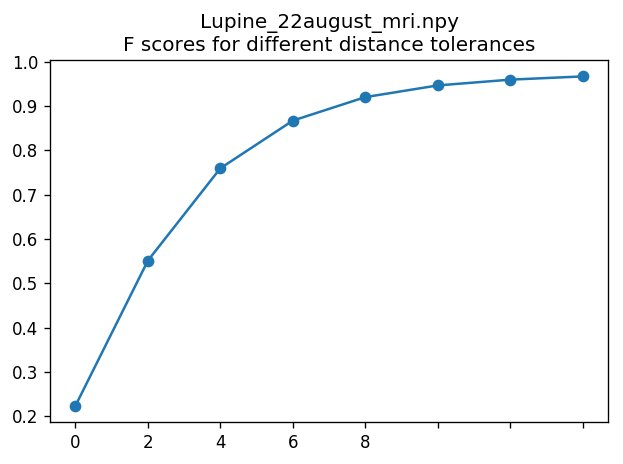

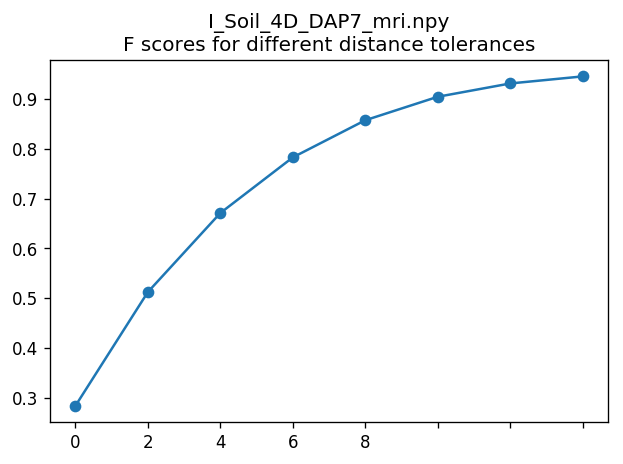

In [52]:
plot_fscore_for_each_data(real_data_F_list_dict, x_list=distance_tolerance_range, title='F scores for different distance tolerances')
